In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500
paises = ['México', 'Colombia', 'Venezuela']
prob_pais = [0.45, 0.45, 0.1]
np.random.choice(paises, size=n_samples, p=prob_pais)

# --------------------------
# 1. Generación de Datos de la Encuesta Completa
# --------------------------
# Aquí simulamos datos para todas las preguntas de la encuesta.

data = {
    # Sección II: Demográfica y Profesional
    'pais': np.random.choice(paises, size=n_samples, p=prob_pais),
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]),
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]),
    'años_experiencia': np.random.randint(1, 40, size=n_samples),
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]),
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]),
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]),
    
    # Sección III: Adopción y Uso de IA
    'conocimiento_IA_nivel': np.random.randint(1, 6, size=n_samples), # Pregunta 9
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]),
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección IV: Percepción de la IA (Preguntas 13-21)
    **{f'percepcion_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(13, 22)},

    # Sección V: Impacto en la Profesión (Preguntas 22-28)
    **{f'impacto_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(22, 29)},

    # Sección VI: Barreras y Facilitadores (Preguntas 29-32)
    **{f'barrera_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(29, 33)},
    
    # Sección VII: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # Pregunta 33
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección VIII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples),
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples),
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples),
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples),
}

df = pd.DataFrame(data)

# Mapear rango de edad a valor numérico para correlación
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['edad_numerica', 'años_experiencia', 'conocimiento_IA_nivel', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()
    

# --------------------------
# 3. Comparaciones entre Países (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Países ---")
# ANOVA: Conocimiento de IA por País
grupos_conocimiento = [df[df['pais'] == p]['conocimiento_IA_nivel'] for p in paises]
f_stat, p_value_anova = f_oneway(*grupos_conocimiento, nan_policy='omit')
print(f"\n[ANOVA] Conocimiento de IA por País: p-valor = {p_value_anova:.4f}")
print("  - Diferencia significativa si p < 0.05.")

# T-tests: Comparación por Género por País
for pais in paises:
    print(f"\n[T-test] para {pais}")
    df_pais = df[df['pais'] == pais]
    hombres = df_pais[df_pais['genero'] == 'Masculino']['conocimiento_IA_nivel']
    mujeres = df_pais[df_pais['genero'] == 'Femenino']['conocimiento_IA_nivel']
    if len(hombres) > 1 and len(mujeres) > 1:
        t_stat, p_value_ttest = ttest_ind(hombres, mujeres, nan_policy='omit')
        print(f"  - Conocimiento de IA vs. Género: p-valor = {p_value_ttest:.4f}")
        print("    - Diferencia significativa si p < 0.05.")

# --------------------------
# 4. Análisis de Regresión y Coeficientes Beta
# --------------------------
# Este modelo predice el uso de IA (variable binaria)
# basado en otras variables numéricas y categóricas.

print("\n\n--- Análisis de Regresión y Coeficientes Beta ---")
df_reg = df.copy()
# Variables dummy para el modelo de regresión
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

variables_predictoras = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'años_experiencia', 'edad_numerica'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)
X = df_reg[variables_predictoras]
y = df_reg['uso_herramientas_IA']
X = sm.add_constant(X)
modelo_logistico = sm.Logit(y, X).fit()

print("\n[Resumen del Modelo de Regresión Logística]")
print(modelo_logistico.summary())

# Explicación del Coeficiente Beta
print("\n--- Explicación del Coeficiente Beta (ß) ---")
print("El Coeficiente Beta (β) en la tabla del resumen indica la relación entre cada variable predictora y la variable de resultado (`uso_herramientas_IA`).")
print("  - Un β positivo significa que un aumento en la variable predictora (ej. más conocimiento) aumenta la probabilidad de que el resultado ocurra (ej. usar IA).")
print("  - Un β negativo significa que un aumento en la variable predictora disminuye la probabilidad de que el resultado ocurra.")
print("  - La importancia de cada β se evalúa con su p-valor (P>|z|). Si es menor a 0.05, el efecto es estadísticamente significativo.")
print("Por ejemplo, un β = 0.8 en `conocimiento_IA_nivel` con un p-valor de 0.001 (muy bajo) indicaría que el nivel de conocimiento es un predictor fuerte y positivo del uso de la IA.")

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------

def analizar_sentimiento(df_to_analyze, column_name):
    df_to_analyze[f'sentimiento_{column_name}'] = df_to_analyze[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_to_analyze

print("\n\n--- Análisis de Sentimiento por País ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")

ModuleNotFoundError: No module named 'textblob'

In [2]:
pip install textblob


   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   --------------------------------- ------ 524.3/624.3 kB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 624.3/624.3 kB 5.8 MB/s eta 0:00:00




--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


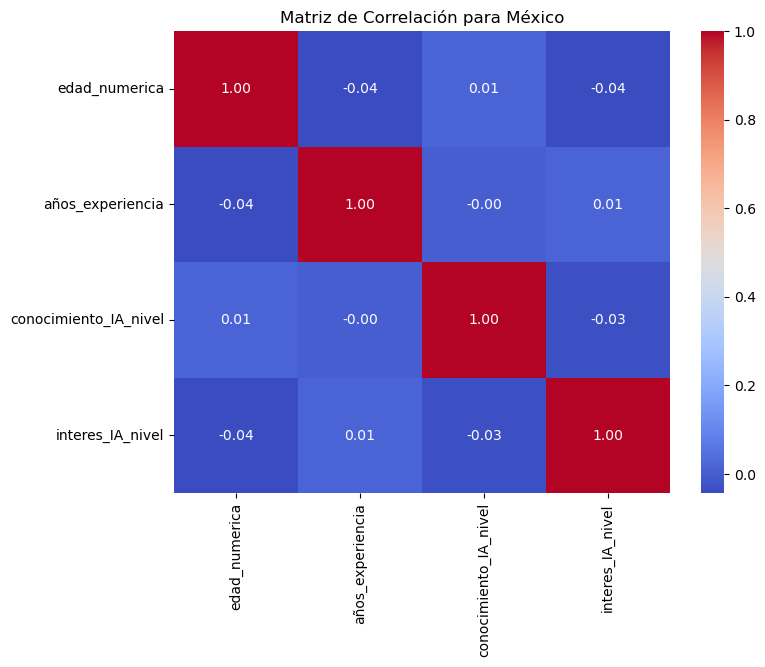


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


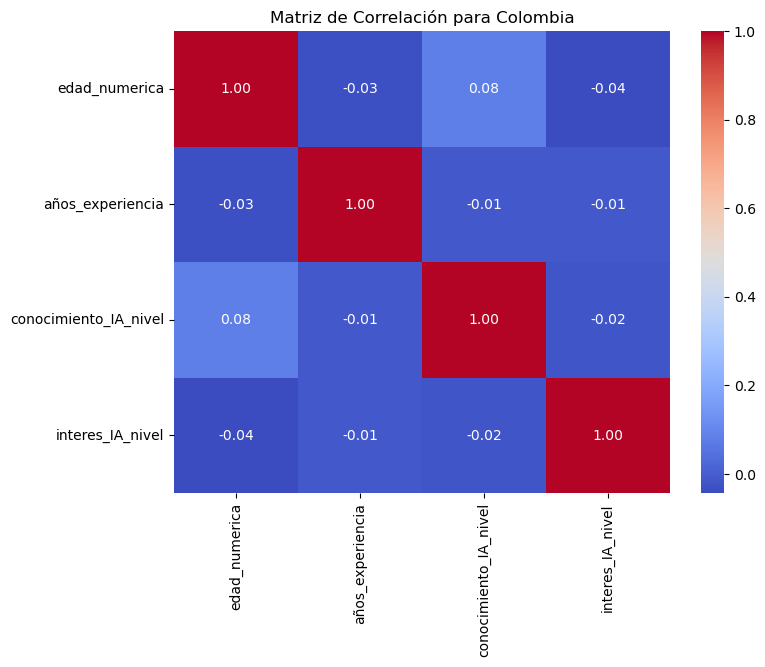


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


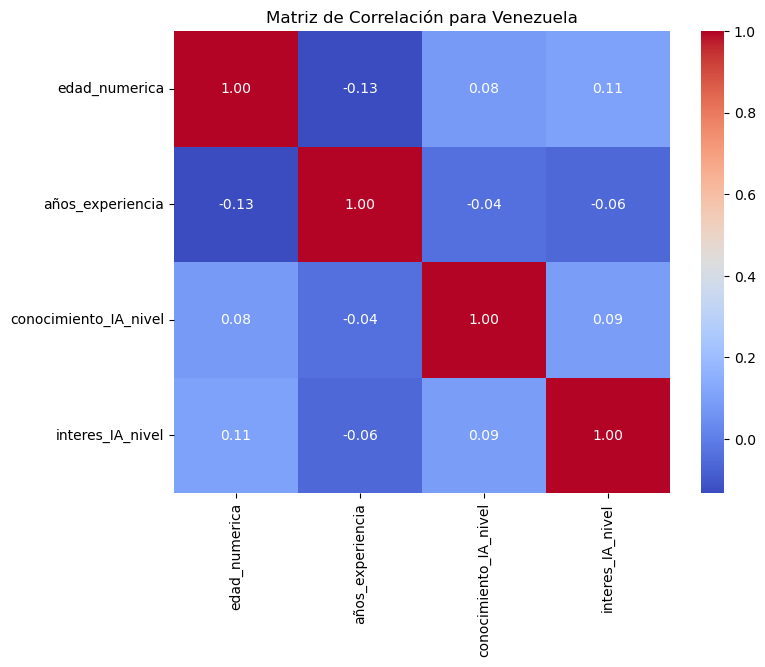



--- Comparaciones de Medias entre Países ---

[ANOVA] Conocimiento de IA por País: p-valor = 0.8806
  - Diferencia significativa si p < 0.05.

[T-test] para México
  - Conocimiento de IA vs. Género: p-valor = 0.5814
    - Diferencia significativa si p < 0.05.

[T-test] para Colombia
  - Conocimiento de IA vs. Género: p-valor = 0.9255
    - Diferencia significativa si p < 0.05.

[T-test] para Venezuela
  - Conocimiento de IA vs. Género: p-valor = 0.2655
    - Diferencia significativa si p < 0.05.


--- Análisis de Regresión y Coeficientes Beta ---


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500
paises = ['México', 'Colombia', 'Venezuela']
prob_pais = [0.45, 0.45, 0.1]
np.random.choice(paises, size=n_samples, p=prob_pais)

# --------------------------
# 1. Generación de Datos de la Encuesta Completa
# --------------------------
# Aquí simulamos datos para todas las preguntas de la encuesta.

data = {
    # Sección II: Demográfica y Profesional
    'pais': np.random.choice(paises, size=n_samples, p=prob_pais),
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]),
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]),
    'años_experiencia': np.random.randint(1, 40, size=n_samples),
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]),
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]),
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]),
    
    # Sección III: Adopción y Uso de IA
    'conocimiento_IA_nivel': np.random.randint(1, 6, size=n_samples), # Pregunta 9
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]),
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección IV: Percepción de la IA (Preguntas 13-21)
    **{f'percepcion_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(13, 22)},

    # Sección V: Impacto en la Profesión (Preguntas 22-28)
    **{f'impacto_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(22, 29)},

    # Sección VI: Barreras y Facilitadores (Preguntas 29-32)
    **{f'barrera_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(29, 33)},
    
    # Sección VII: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # Pregunta 33
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección VIII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples),
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples),
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples),
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples),
}

df = pd.DataFrame(data)

# Mapear rango de edad a valor numérico para correlación
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['edad_numerica', 'años_experiencia', 'conocimiento_IA_nivel', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Países (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Países ---")
# ANOVA: Conocimiento de IA por País
grupos_conocimiento = [df[df['pais'] == p]['conocimiento_IA_nivel'] for p in paises]
f_stat, p_value_anova = f_oneway(*grupos_conocimiento, nan_policy='omit')
print(f"\n[ANOVA] Conocimiento de IA por País: p-valor = {p_value_anova:.4f}")
print("  - Diferencia significativa si p < 0.05.")

# T-tests: Comparación por Género por País
for pais in paises:
    print(f"\n[T-test] para {pais}")
    df_pais = df[df['pais'] == pais]
    hombres = df_pais[df_pais['genero'] == 'Masculino']['conocimiento_IA_nivel']
    mujeres = df_pais[df_pais['genero'] == 'Femenino']['conocimiento_IA_nivel']
    if len(hombres) > 1 and len(mujeres) > 1:
        t_stat, p_value_ttest = ttest_ind(hombres, mujeres, nan_policy='omit')
        print(f"  - Conocimiento de IA vs. Género: p-valor = {p_value_ttest:.4f}")
        print("    - Diferencia significativa si p < 0.05.")

# --------------------------
# 4. Análisis de Regresión y Coeficientes Beta
# --------------------------
# Este modelo predice el uso de IA (variable binaria)
# basado en otras variables numéricas y categóricas.

print("\n\n--- Análisis de Regresión y Coeficientes Beta ---")
df_reg = df.copy()
# Variables dummy para el modelo de regresión
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

variables_predictoras = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'años_experiencia', 'edad_numerica'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)
X = df_reg[variables_predictoras]
y = df_reg['uso_herramientas_IA']
X = sm.add_constant(X)
modelo_logistico = sm.Logit(y, X).fit()

print("\n[Resumen del Modelo de Regresión Logística]")
print(modelo_logistico.summary())

# Explicación del Coeficiente Beta
print("\n--- Explicación del Coeficiente Beta (ß) ---")
print("El Coeficiente Beta (β) en la tabla del resumen indica la relación entre cada variable predictora y la variable de resultado (`uso_herramientas_IA`).")
print("  - Un β positivo significa que un aumento en la variable predictora (ej. más conocimiento) aumenta la probabilidad de que el resultado ocurra (ej. usar IA).")
print("  - Un β negativo significa que un aumento en la variable predictora disminuye la probabilidad de que el resultado ocurra.")
print("  - La importancia de cada β se evalúa con su p-valor (P>|z|). Si es menor a 0.05, el efecto es estadísticamente significativo.")
print("Por ejemplo, un β = 0.8 en `conocimiento_IA_nivel` con un p-valor de 0.001 (muy bajo) indicaría que el nivel de conocimiento es un predictor fuerte y positivo del uso de la IA.")

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------

def analizar_sentimiento(df_to_analyze, column_name):
    df_to_analyze[f'sentimiento_{column_name}'] = df_to_analyze[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_to_analyze

print("\n\n--- Análisis de Sentimiento por País ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


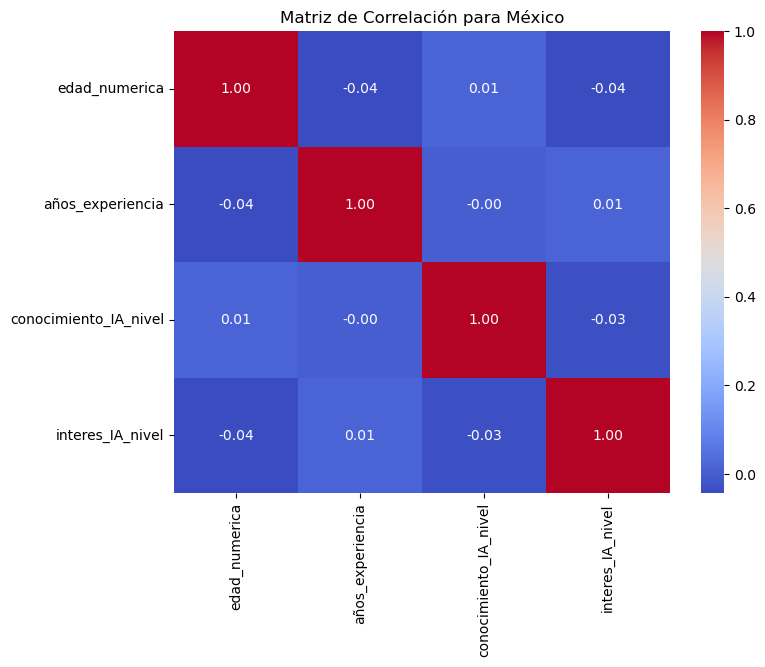


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


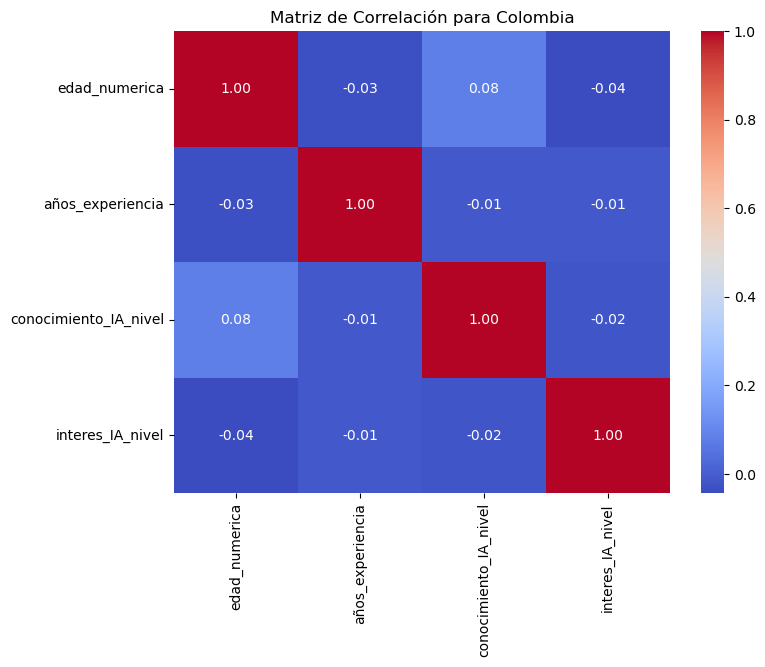


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


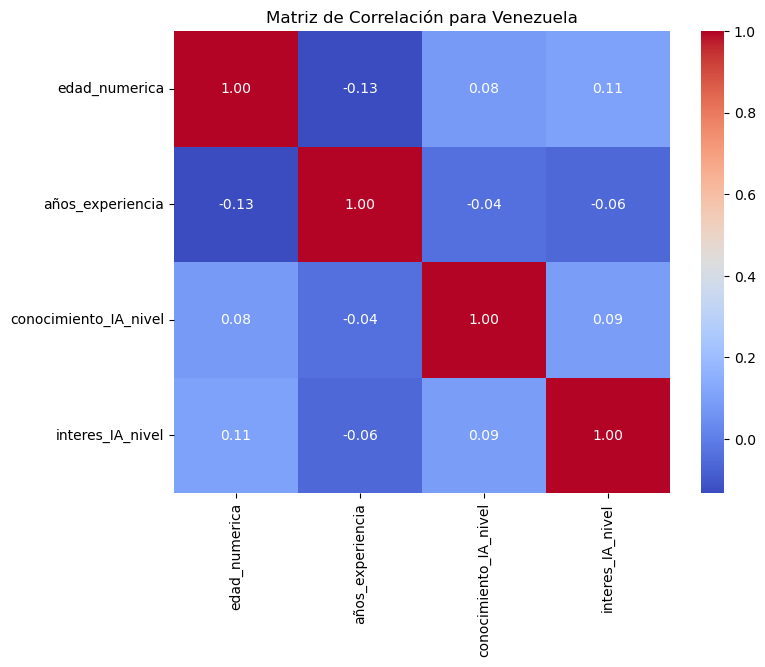



--- Comparaciones de Medias entre Países ---

[ANOVA] Conocimiento de IA por País: p-valor = 0.8806
  - Diferencia significativa si p < 0.05.

[T-test] para México
  - Conocimiento de IA vs. Género: p-valor = 0.5814
    - Diferencia significativa si p < 0.05.

[T-test] para Colombia
  - Conocimiento de IA vs. Género: p-valor = 0.9255
    - Diferencia significativa si p < 0.05.

[T-test] para Venezuela
  - Conocimiento de IA vs. Género: p-valor = 0.2655
    - Diferencia significativa si p < 0.05.


--- Análisis de Regresión y Coeficientes Beta ---
Optimization terminated successfully.
         Current function value: 0.643534
         Iterations 5

[Resumen del Modelo de Regresión Logística]
                            Logit Regression Results                           
Dep. Variable:     uso_herramientas_IA   No. Observations:                  500
Model:                           Logit   Df Residuals:                      477
Method:                            MLE   Df Model:        

C:\Users\abrah\AppData\Local\Temp\ipykernel_22412\1941298155.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_analyze[f'sentimiento_{column_name}'] = df_to_analyze[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
C:\Users\abrah\AppData\Local\Temp\ipykernel_22412\1941298155.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_analyze[f'sentimiento_{column_name}'] = df_to_analyze[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
C:\Users\abrah\AppData\Local\T

  - Sentimiento de 'oportunidad_abierta': Polaridad promedio = 0.00 (Neutral)
  - Sentimiento de 'riesgo_abierta': Polaridad promedio = 0.00 (Neutral)
  - Sentimiento de 'condiciones_abierta': Polaridad promedio = 0.00 (Neutral)
  - Sentimiento de 'consejo_abierta': Polaridad promedio = 0.00 (Neutral)

[Resultados de Sentimiento para Colombia]
  - Sentimiento de 'oportunidad_abierta': Polaridad promedio = 0.00 (Neutral)
  - Sentimiento de 'riesgo_abierta': Polaridad promedio = 0.00 (Neutral)
  - Sentimiento de 'condiciones_abierta': Polaridad promedio = 0.00 (Neutral)
  - Sentimiento de 'consejo_abierta': Polaridad promedio = 0.00 (Neutral)

[Resultados de Sentimiento para Venezuela]
  - Sentimiento de 'oportunidad_abierta': Polaridad promedio = 0.00 (Neutral)
  - Sentimiento de 'riesgo_abierta': Polaridad promedio = 0.00 (Neutral)
  - Sentimiento de 'condiciones_abierta': Polaridad promedio = 0.00 (Neutral)
  - Sentimiento de 'consejo_abierta': Polaridad promedio = 0.00 (Neutral)


C:\Users\abrah\AppData\Local\Temp\ipykernel_22412\1941298155.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_analyze[f'sentimiento_{column_name}'] = df_to_analyze[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
C:\Users\abrah\AppData\Local\Temp\ipykernel_22412\1941298155.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_analyze[f'sentimiento_{column_name}'] = df_to_analyze[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
C:\Users\abrah\AppData\Local\T

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500
paises = ['México', 'Colombia', 'Venezuela']
prob_pais = [0.45, 0.45, 0.1]
np.random.choice(paises, size=n_samples, p=prob_pais)

# --------------------------
# 1. Generación de Datos de la Encuesta Completa
# --------------------------
# Aquí simulamos datos para todas las preguntas de la encuesta.

data = {
    # Sección II: Demográfica y Profesional
    'pais': np.random.choice(paises, size=n_samples, p=prob_pais),
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]),
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]),
    'años_experiencia': np.random.randint(1, 40, size=n_samples),
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]),
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]),
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]),
    
    # Sección III: Adopción y Uso de IA
    'conocimiento_IA_nivel': np.random.randint(1, 6, size=n_samples), # Pregunta 9
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]),
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección IV: Percepción de la IA (Preguntas 13-21)
    **{f'percepcion_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(13, 22)},

    # Sección V: Impacto en la Profesión (Preguntas 22-28)
    **{f'impacto_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(22, 29)},

    # Sección VI: Barreras y Facilitadores (Preguntas 29-32)
    **{f'barrera_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(29, 33)},
    
    # Sección VII: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # Pregunta 33
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección VIII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples),
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples),
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples),
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples),
}

df = pd.DataFrame(data)

# Mapear rango de edad a valor numérico para correlación
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['edad_numerica', 'años_experiencia', 'conocimiento_IA_nivel', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Países (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Países ---")
# ANOVA: Conocimiento de IA por País
grupos_conocimiento = [df[df['pais'] == p]['conocimiento_IA_nivel'] for p in paises]
f_stat, p_value_anova = f_oneway(*grupos_conocimiento, nan_policy='omit')
print(f"\n[ANOVA] Conocimiento de IA por País: p-valor = {p_value_anova:.4f}")
print("  - Diferencia significativa si p < 0.05.")

# T-tests: Comparación por Género por País
for pais in paises:
    print(f"\n[T-test] para {pais}")
    df_pais = df[df['pais'] == pais]
    hombres = df_pais[df_pais['genero'] == 'Masculino']['conocimiento_IA_nivel']
    mujeres = df_pais[df_pais['genero'] == 'Femenino']['conocimiento_IA_nivel']
    if len(hombres) > 1 and len(mujeres) > 1:
        t_stat, p_value_ttest = ttest_ind(hombres, mujeres, nan_policy='omit')
        print(f"  - Conocimiento de IA vs. Género: p-valor = {p_value_ttest:.4f}")
        print("    - Diferencia significativa si p < 0.05.")

# --------------------------
# 4. Análisis de Regresión y Coeficientes Beta
# --------------------------
# Este modelo predice el uso de IA (variable binaria)
# basado en otras variables numéricas y categóricas.

print("\n\n--- Análisis de Regresión y Coeficientes Beta ---")
df_reg = df.copy()
# Variables dummy para el modelo de regresión
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

variables_predictoras = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'años_experiencia', 'edad_numerica'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)
X = df_reg[variables_predictoras].astype(float)
y = df_reg['uso_herramientas_IA']
X = sm.add_constant(X)
modelo_logistico = sm.Logit(y, X).fit()

print("\n[Resumen del Modelo de Regresión Logística]")
print(modelo_logistico.summary())

# Explicación del Coeficiente Beta
print("\n--- Explicación del Coeficiente Beta (ß) ---")
print("El Coeficiente Beta (β) en la tabla del resumen indica la relación entre cada variable predictora y la variable de resultado (`uso_herramientas_IA`).")
print("  - Un β positivo significa que un aumento en la variable predictora (ej. más conocimiento) aumenta la probabilidad de que el resultado ocurra (ej. usar IA).")
print("  - Un β negativo significa que un aumento en la variable predictora disminuye la probabilidad de que el resultado ocurra.")
print("  - La importancia de cada β se evalúa con su p-valor (P>|z|). Si es menor a 0.05, el efecto es estadísticamente significativo.")
print("Por ejemplo, un β = 0.8 en `conocimiento_IA_nivel` con un p-valor de 0.001 (muy bajo) indicaría que el nivel de conocimiento es un predictor fuerte y positivo del uso de la IA.")

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------

def analizar_sentimiento(df_to_analyze, column_name):
    df_to_analyze[f'sentimiento_{column_name}'] = df_to_analyze[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_to_analyze

print("\n\n--- Análisis de Sentimiento por País ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


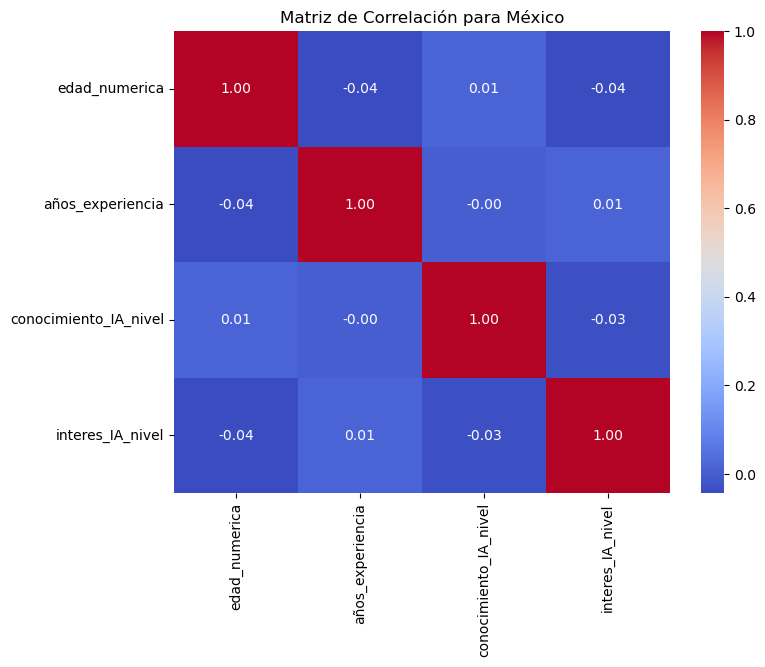


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


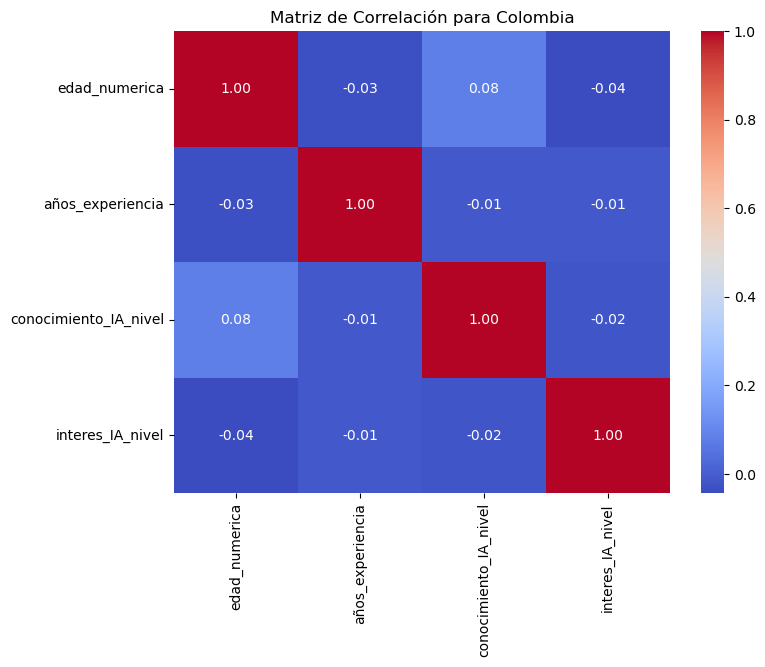


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


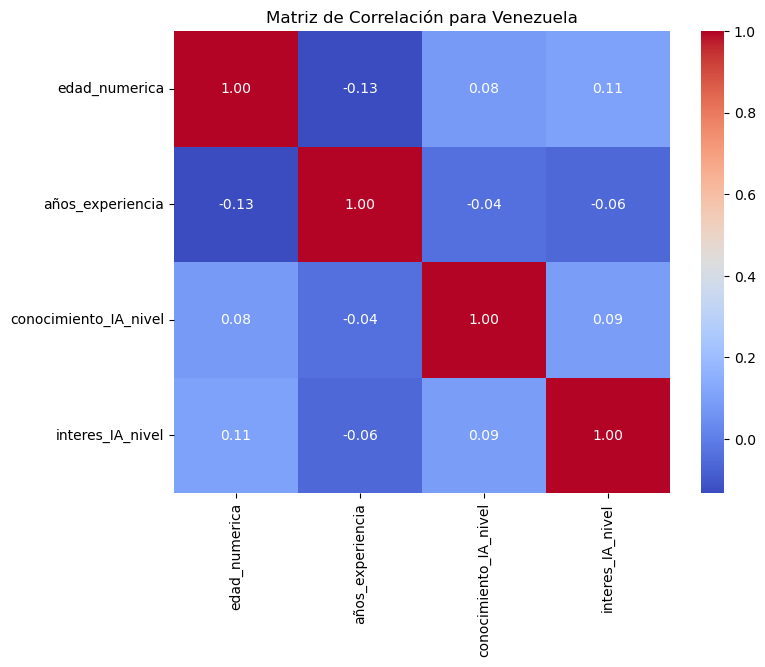



--- Comparaciones de Medias entre Países ---

[ANOVA] Conocimiento de IA por País: p-valor = 0.8806
  - Diferencia significativa si p < 0.05.

[T-test] para México
  - Conocimiento de IA vs. Género: p-valor = 0.5814
    - Diferencia significativa si p < 0.05.

[T-test] para Colombia
  - Conocimiento de IA vs. Género: p-valor = 0.9255
    - Diferencia significativa si p < 0.05.

[T-test] para Venezuela
  - Conocimiento de IA vs. Género: p-valor = 0.2655
    - Diferencia significativa si p < 0.05.


--- Análisis de Regresión y Coeficientes Beta ---
Optimization terminated successfully.
         Current function value: 0.643534
         Iterations 5

[Resumen del Modelo de Regresión Logística]
                            Logit Regression Results                           
Dep. Variable:     uso_herramientas_IA   No. Observations:                  500
Model:                           Logit   Df Residuals:                      477
Method:                            MLE   Df Model:        

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500
paises = ['México', 'Colombia', 'Venezuela']
prob_pais = [0.45, 0.45, 0.1]
np.random.choice(paises, size=n_samples, p=prob_pais)

# --------------------------
# 1. Generación de Datos de la Encuesta Completa
# --------------------------
# Aquí simulamos datos para todas las preguntas de la encuesta.

data = {
    # Sección II: Demográfica y Profesional
    'pais': np.random.choice(paises, size=n_samples, p=prob_pais),
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]),
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]),
    'años_experiencia': np.random.randint(1, 40, size=n_samples),
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]),
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]),
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]),
    
    # Sección III: Adopción y Uso de IA
    'conocimiento_IA_nivel': np.random.randint(1, 6, size=n_samples), # Pregunta 9
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]),
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección IV: Percepción de la IA (Preguntas 13-21)
    **{f'percepcion_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(13, 22)},

    # Sección V: Impacto en la Profesión (Preguntas 22-28)
    **{f'impacto_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(22, 29)},

    # Sección VI: Barreras y Facilitadores (Preguntas 29-32)
    **{f'barrera_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(29, 33)},
    
    # Sección VII: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # Pregunta 33
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección VIII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples),
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples),
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples),
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples),
}

df = pd.DataFrame(data)

# Mapear rango de edad a valor numérico para correlación
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['edad_numerica', 'años_experiencia', 'conocimiento_IA_nivel', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Países (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Países ---")
# ANOVA: Conocimiento de IA por País
grupos_conocimiento = [df[df['pais'] == p]['conocimiento_IA_nivel'] for p in paises]
f_stat, p_value_anova = f_oneway(*grupos_conocimiento, nan_policy='omit')
print(f"\n[ANOVA] Conocimiento de IA por País: p-valor = {p_value_anova:.4f}")
print("  - Diferencia significativa si p < 0.05.")

# T-tests: Comparación por Género por País
for pais in paises:
    print(f"\n[T-test] para {pais}")
    df_pais = df[df['pais'] == pais]
    hombres = df_pais[df_pais['genero'] == 'Masculino']['conocimiento_IA_nivel']
    mujeres = df_pais[df_pais['genero'] == 'Femenino']['conocimiento_IA_nivel']
    if len(hombres) > 1 and len(mujeres) > 1:
        t_stat, p_value_ttest = ttest_ind(hombres, mujeres, nan_policy='omit')
        print(f"  - Conocimiento de IA vs. Género: p-valor = {p_value_ttest:.4f}")
        print("    - Diferencia significativa si p < 0.05.")

# --------------------------
# 4. Análisis de Regresión y Coeficientes Beta
# --------------------------
# Este modelo predice el uso de IA (variable binaria)
# basado en otras variables numéricas y categóricas.

print("\n\n--- Análisis de Regresión y Coeficientes Beta ---")
df_reg = df.copy()
# Variables dummy para el modelo de regresión
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

variables_predictoras = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'años_experiencia', 'edad_numerica'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)
X = df_reg[variables_predictoras].astype(float)
y = df_reg['uso_herramientas_IA']
X = sm.add_constant(X)
modelo_logistico = sm.Logit(y, X).fit()

print("\n[Resumen del Modelo de Regresión Logística]")
print(modelo_logistico.summary())

# Explicación del Coeficiente Beta
print("\n--- Explicación del Coeficiente Beta (ß) ---")
print("El Coeficiente Beta (β) en la tabla del resumen indica la relación entre cada variable predictora y la variable de resultado (`uso_herramientas_IA`).")
print("  - Un β positivo significa que un aumento en la variable predictora (ej. más conocimiento) aumenta la probabilidad de que el resultado ocurra (ej. usar IA).")
print("  - Un β negativo significa que un aumento en la variable predictora disminuye la probabilidad de que el resultado ocurra.")
print("  - La importancia de cada β se evalúa con su p-valor (P>|z|). Si es menor a 0.05, el efecto es estadísticamente significativo.")
print("Por ejemplo, un β = 0.8 en `conocimiento_IA_nivel` con un p-valor de 0.001 (muy bajo) indicaría que el nivel de conocimiento es un predictor fuerte y positivo del uso de la IA.")

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------

def analizar_sentimiento(df_to_analyze, column_name):
    # Usamos .loc para asegurar que se modifica una copia del DataFrame
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento por País ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


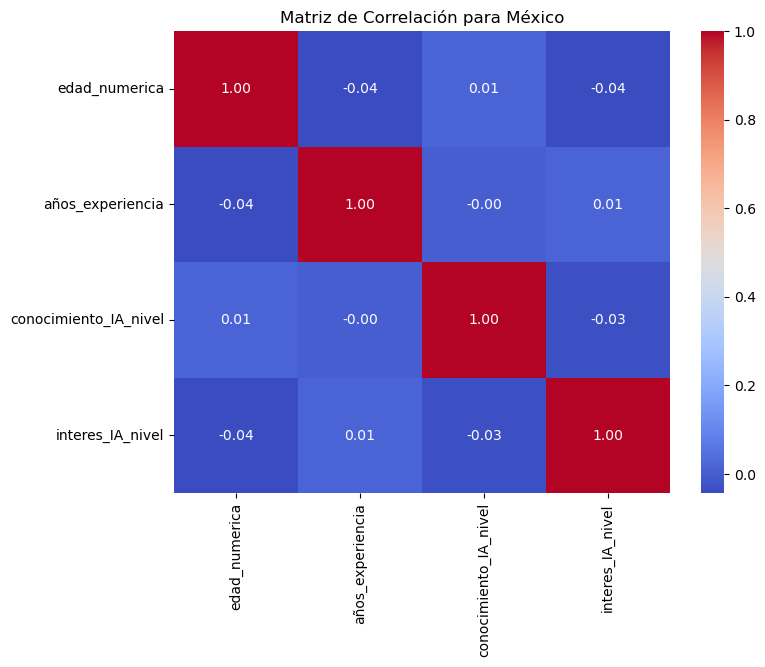


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


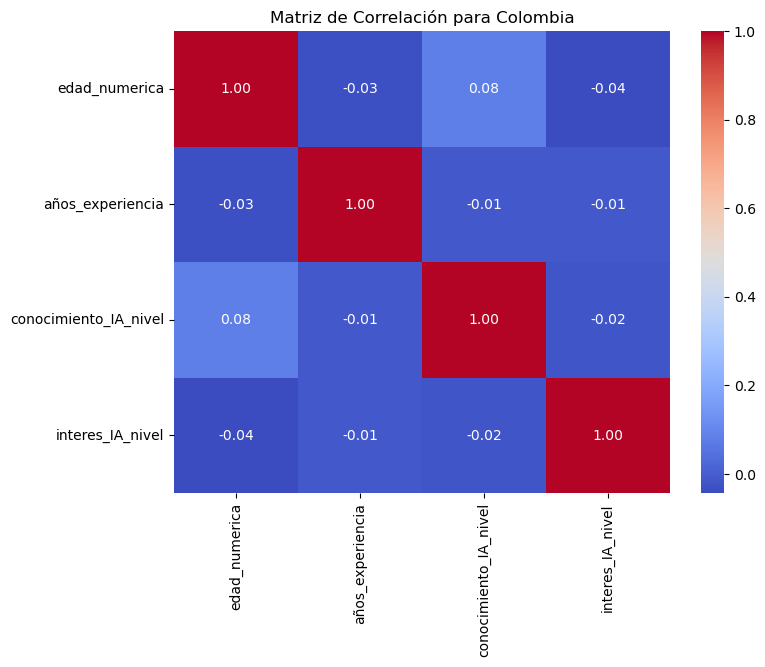


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


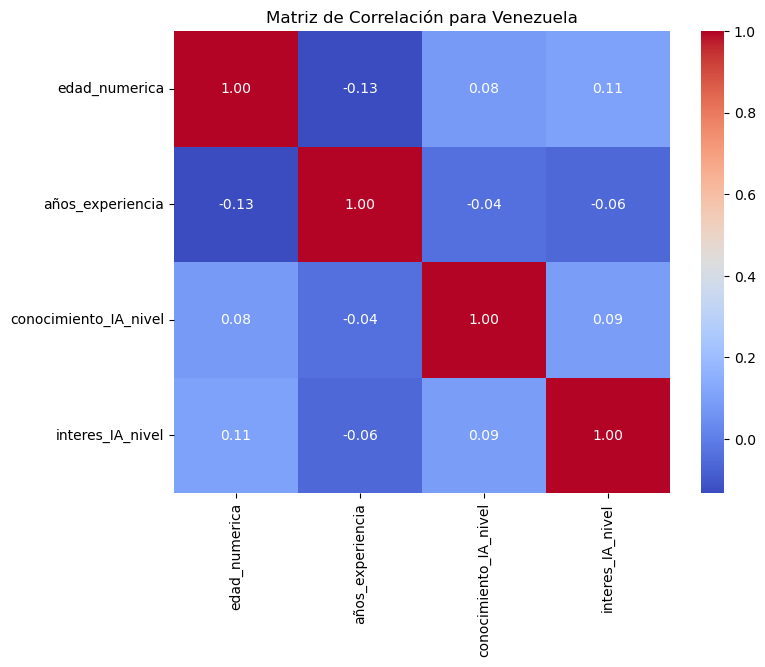



--- Comparaciones de Medias entre Países ---

[ANOVA] Comparando 'conocimiento_IA_nivel' por País:
  - p-valor = 0.8806
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_IA_13' por País:
  - p-valor = 0.1608
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_IA_22' por País:
  - p-valor = 0.5062
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'barrera_IA_29' por País:
  - p-valor = 0.6202
  - No hay una diferencia significativa entre los países en esta variable.

[T-test] para México
  - 'conocimiento_IA_nivel' vs. Género: p-valor = 0.5814
  - 'conocimiento_IA_nivel' vs. Uso de IA: p-valor = 0.7222
  - 'interes_IA_nivel' vs. Género: p-valor = 0.7644
  - 'interes_IA_nivel' vs. Uso de IA: p-valor = 0.1581
  - 'percepcion_IA_13' vs. Género: p-valor = 0.0662
  - 'percepcion_IA_13' vs. Uso de IA: p-valor = 0.3158
  - 'impacto_IA_22' v

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500
paises = ['México', 'Colombia', 'Venezuela']
prob_pais = [0.45, 0.45, 0.1]
np.random.choice(paises, size=n_samples, p=prob_pais)

# --------------------------
# 1. Generación de Datos de la Encuesta Completa
# --------------------------
data = {
    # Sección II: Demográfica y Profesional
    'pais': np.random.choice(paises, size=n_samples, p=prob_pais),
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]),
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]),
    'años_experiencia': np.random.randint(1, 40, size=n_samples),
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]),
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]),
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]),
    
    # Sección III: Adopción y Uso de IA
    'conocimiento_IA_nivel': np.random.randint(1, 6, size=n_samples), # P9
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]),
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección IV: Percepción de la IA (P13-21)
    **{f'percepcion_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(13, 22)},

    # Sección V: Impacto en la Profesión (P22-28)
    **{f'impacto_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(22, 29)},

    # Sección VI: Barreras y Facilitadores (P29-32)
    **{f'barrera_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(29, 33)},
    
    # Sección VII: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P33
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección VIII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples),
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples),
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples),
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples),
}

df = pd.DataFrame(data)

# Mapear rango de edad a valor numérico para correlación
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['edad_numerica', 'años_experiencia', 'conocimiento_IA_nivel', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Países (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Países ---")
# ANOVA: Comparando variables clave entre países
variables_anova = ['conocimiento_IA_nivel', 'percepcion_IA_13', 'impacto_IA_22', 'barrera_IA_29']
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

# T-tests: Comparando grupos dentro de cada país
variables_ttest = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'percepcion_IA_13', 'impacto_IA_22']
for pais in paises:
    print(f"\n[T-test] para {pais}")
    df_pais = df[df['pais'] == pais]
    
    for var in variables_ttest:
        # Comparación por Género
        hombres = df_pais[df_pais['genero'] == 'Masculino'][var]
        mujeres = df_pais[df_pais['genero'] == 'Femenino'][var]
        if len(hombres) > 1 and len(mujeres) > 1:
            t_stat, p_value = ttest_ind(hombres, mujeres, nan_policy='omit')
            print(f"  - '{var}' vs. Género: p-valor = {p_value:.4f}")

        # Comparación por Uso de IA
        usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'Si'][var]
        no_usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'No'][var]
        if len(usa_ia) > 1 and len(no_usa_ia) > 1:
            t_stat, p_value = ttest_ind(usa_ia, no_usa_ia, nan_policy='omit')
            print(f"  - '{var}' vs. Uso de IA: p-valor = {p_value:.4f}")

# --------------------------
# 4. Análisis de Regresión y Coeficientes Beta
# --------------------------
print("\n\n--- Análisis de Regresión y Coeficientes Beta ---")
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)
variables_predictoras = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'años_experiencia', 'edad_numerica'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)
X = df_reg[variables_predictoras].astype(float)
y = df_reg['uso_herramientas_IA']
X = sm.add_constant(X)
modelo_logistico = sm.Logit(y, X).fit()
print("\n[Resumen del Modelo de Regresión Logística]")
print(modelo_logistico.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento por País ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


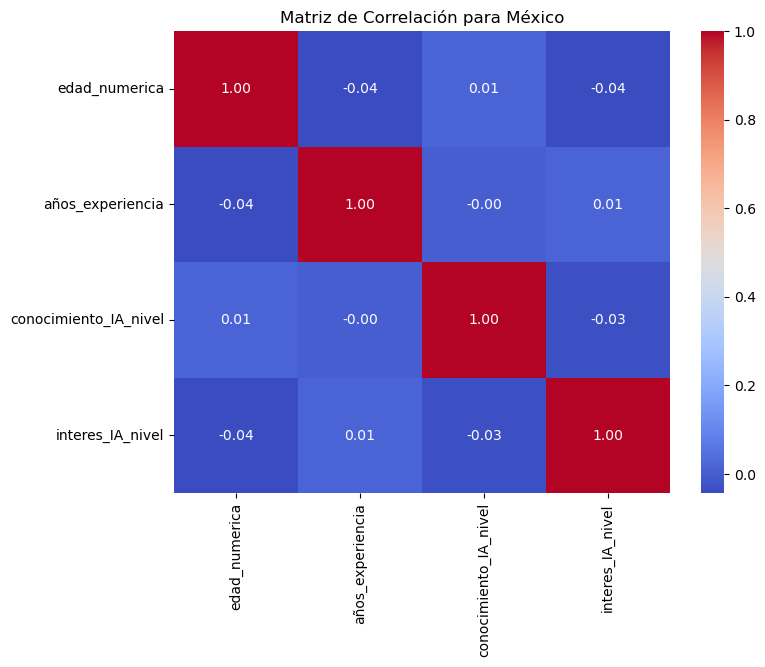


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


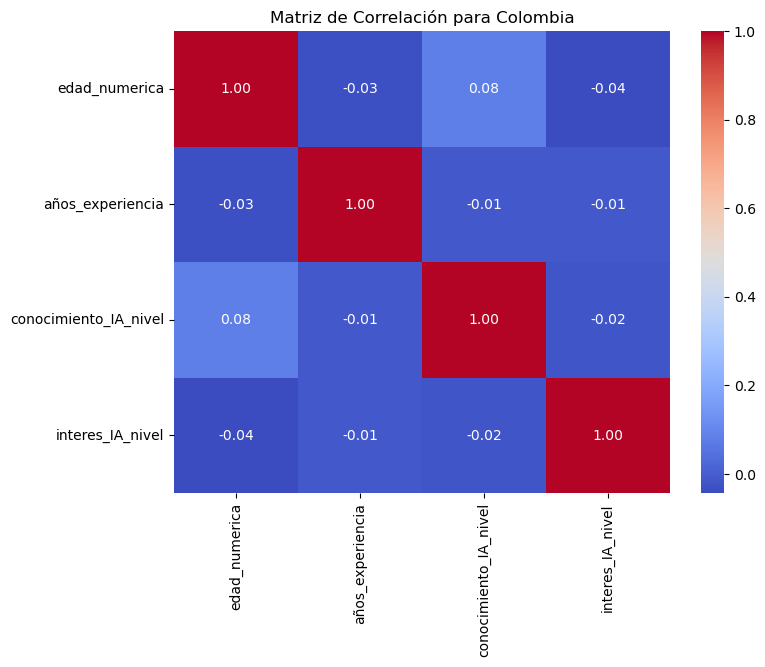


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


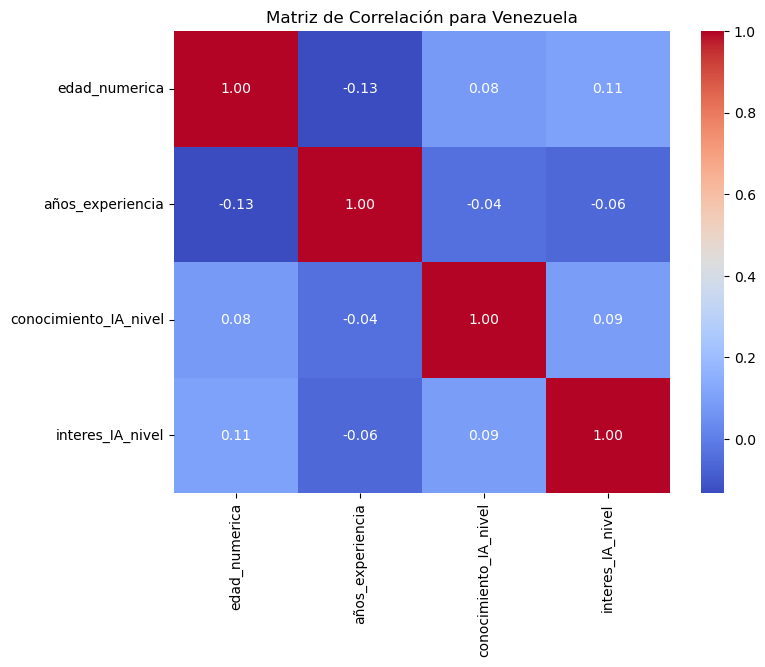



--- Comparaciones de Medias entre Países ---

[ANOVA] Comparando 'conocimiento_IA_nivel' por País:
  - p-valor = 0.8806
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_IA_13' por País:
  - p-valor = 0.1608
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_IA_22' por País:
  - p-valor = 0.5062
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'barrera_IA_29' por País:
  - p-valor = 0.6202
  - No hay una diferencia significativa entre los países en esta variable.

[T-test] para México
  - 'conocimiento_IA_nivel' vs. Género: p-valor = 0.5814
  - 'conocimiento_IA_nivel' vs. Uso de IA: p-valor = 0.7222
  - 'interes_IA_nivel' vs. Género: p-valor = 0.7644
  - 'interes_IA_nivel' vs. Uso de IA: p-valor = 0.1581
  - 'percepcion_IA_13' vs. Género: p-valor = 0.0662
  - 'percepcion_IA_13' vs. Uso de IA: p-valor = 0.3158
  - 'impacto_IA_22' v

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500
paises = ['México', 'Colombia', 'Venezuela']
prob_pais = [0.45, 0.45, 0.1]
np.random.choice(paises, size=n_samples, p=prob_pais)

# --------------------------
# 1. Generación de Datos de la Encuesta Completa
# --------------------------
data = {
    # Sección II: Demográfica y Profesional
    'pais': np.random.choice(paises, size=n_samples, p=prob_pais),
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]),
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]),
    'años_experiencia': np.random.randint(1, 40, size=n_samples),
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]),
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]),
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]),
    
    # Sección III: Adopción y Uso de IA
    'conocimiento_IA_nivel': np.random.randint(1, 6, size=n_samples), # P9
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]),
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección IV: Percepción de la IA (P13-21)
    **{f'percepcion_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(13, 22)},

    # Sección V: Impacto en la Profesión (P22-28)
    **{f'impacto_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(22, 29)},

    # Sección VI: Barreras y Facilitadores (P29-32)
    **{f'barrera_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(29, 33)},
    
    # Sección VII: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P33
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección VIII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples),
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples),
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples),
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples),
}

df = pd.DataFrame(data)

# Mapear rango de edad a valor numérico para correlación
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['edad_numerica', 'años_experiencia', 'conocimiento_IA_nivel', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Países (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Países ---")
variables_anova = ['conocimiento_IA_nivel', 'percepcion_IA_13', 'impacto_IA_22', 'barrera_IA_29']
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

variables_ttest = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'percepcion_IA_13', 'impacto_IA_22']
for pais in paises:
    print(f"\n[T-test] para {pais}")
    df_pais = df[df['pais'] == pais]
    
    for var in variables_ttest:
        hombres = df_pais[df_pais['genero'] == 'Masculino'][var]
        mujeres = df_pais[df_pais['genero'] == 'Femenino'][var]
        if len(hombres) > 1 and len(mujeres) > 1:
            t_stat, p_value = ttest_ind(hombres, mujeres, nan_policy='omit')
            print(f"  - '{var}' vs. Género: p-valor = {p_value:.4f}")

        usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'Si'][var]
        no_usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'No'][var]
        if len(usa_ia) > 1 and len(no_usa_ia) > 1:
            t_stat, p_value = ttest_ind(usa_ia, no_usa_ia, nan_policy='omit')
            print(f"  - '{var}' vs. Uso de IA: p-valor = {p_value:.4f}")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables
# --------------------------

df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)
variables_predictoras = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'años_experiencia', 'edad_numerica'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)
X = df_reg[variables_predictoras].astype(float)
X = sm.add_constant(X)

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
y_uso_ia = df_reg['uso_herramientas_IA']
modelo_logistico = sm.Logit(y_uso_ia, X).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA_nivel' ---")
y_conocimiento = df_reg['conocimiento_IA_nivel']
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
y_interes = df_reg['interes_IA_nivel']
modelo_lineal_interes = sm.OLS(y_interes, X).fit()
print(modelo_lineal_interes.summary())

# --- Modelo 4: Prediciendo la PERCEPCIÓN DE AUTOMATIZACIÓN (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'percepcion_IA_13' ---")
y_percepcion = df_reg['percepcion_IA_13']
modelo_lineal_percepcion = sm.OLS(y_percepcion, X).fit()
print(modelo_lineal_percepcion.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento por País ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


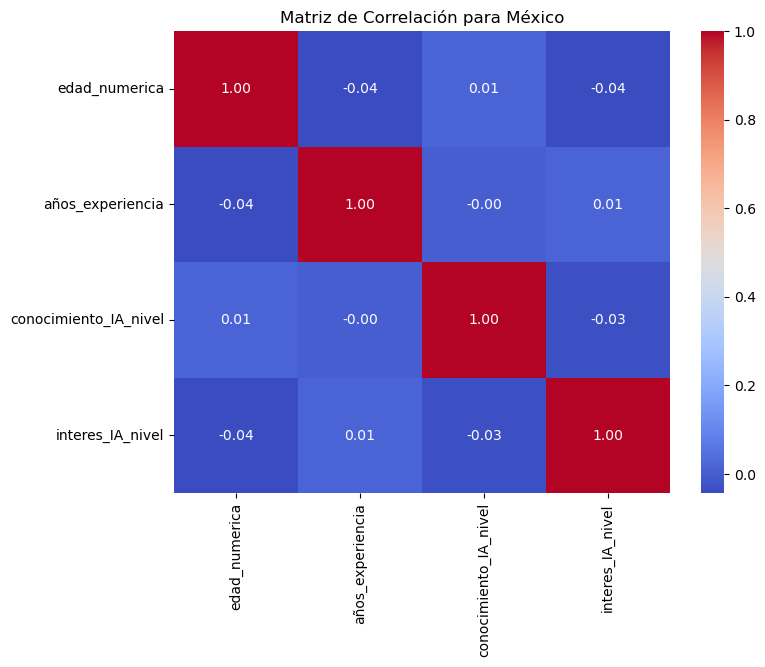


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


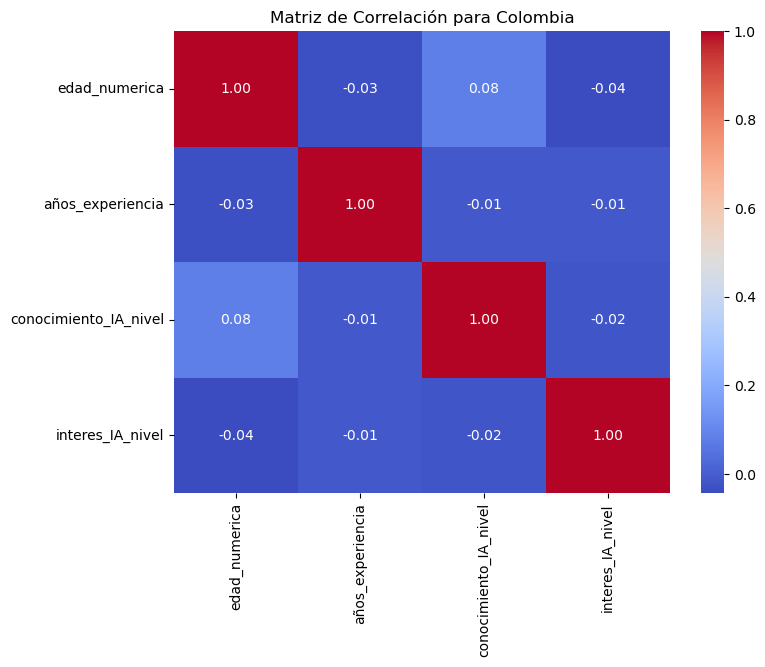


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


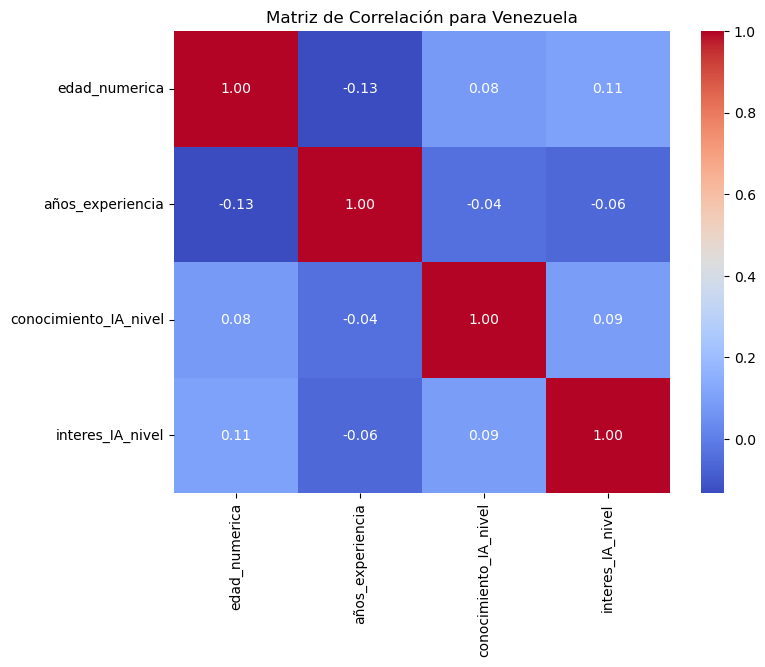



--- Comparaciones de Medias entre Países ---

[ANOVA] Comparando 'conocimiento_IA_nivel' por País:
  - p-valor = 0.8806
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_IA_13' por País:
  - p-valor = 0.1608
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_IA_22' por País:
  - p-valor = 0.5062
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'barrera_IA_29' por País:
  - p-valor = 0.6202
  - No hay una diferencia significativa entre los países en esta variable.

[T-test] para México
  - 'conocimiento_IA_nivel' vs. Género: p-valor = 0.5814
  - 'conocimiento_IA_nivel' vs. Uso de IA: p-valor = 0.7222
  - 'interes_IA_nivel' vs. Género: p-valor = 0.7644
  - 'interes_IA_nivel' vs. Uso de IA: p-valor = 0.1581
  - 'percepcion_IA_13' vs. Género: p-valor = 0.0662
  - 'percepcion_IA_13' vs. Uso de IA: p-valor = 0.3158
  - 'impacto_IA_22' v

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500
paises = ['México', 'Colombia', 'Venezuela']
prob_pais = [0.45, 0.45, 0.1]
np.random.choice(paises, size=n_samples, p=prob_pais)

# --------------------------
# 1. Generación de Datos de la Encuesta Completa
# --------------------------
data = {
    # Sección II: Demográfica y Profesional
    'pais': np.random.choice(paises, size=n_samples, p=prob_pais),
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]),
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]),
    'años_experiencia': np.random.randint(1, 40, size=n_samples),
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]),
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]),
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]),
    
    # Sección III: Adopción y Uso de IA
    'conocimiento_IA_nivel': np.random.randint(1, 6, size=n_samples), # P9
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]),
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección IV: Percepción de la IA (P13-21)
    **{f'percepcion_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(13, 22)},

    # Sección V: Impacto en la Profesión (P22-28)
    **{f'impacto_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(22, 29)},

    # Sección VI: Barreras y Facilitadores (P29-32)
    **{f'barrera_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(29, 33)},
    
    # Sección VII: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P33
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección VIII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples),
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples),
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples),
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples),
}

df = pd.DataFrame(data)

# Mapear rango de edad a valor numérico para correlación
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['edad_numerica', 'años_experiencia', 'conocimiento_IA_nivel', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Países (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Países ---")
variables_anova = ['conocimiento_IA_nivel', 'percepcion_IA_13', 'impacto_IA_22', 'barrera_IA_29']
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

variables_ttest = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'percepcion_IA_13', 'impacto_IA_22']
for pais in paises:
    print(f"\n[T-test] para {pais}")
    df_pais = df[df['pais'] == pais]
    
    for var in variables_ttest:
        hombres = df_pais[df_pais['genero'] == 'Masculino'][var]
        mujeres = df_pais[df_pais['genero'] == 'Femenino'][var]
        if len(hombres) > 1 and len(mujeres) > 1:
            t_stat, p_value = ttest_ind(hombres, mujeres, nan_policy='omit')
            print(f"  - '{var}' vs. Género: p-valor = {p_value:.4f}")

        usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'Si'][var]
        no_usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'No'][var]
        if len(usa_ia) > 1 and len(no_usa_ia) > 1:
            t_stat, p_value = ttest_ind(usa_ia, no_usa_ia, nan_policy='omit')
            print(f"  - '{var}' vs. Uso de IA: p-valor = {p_value:.4f}")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables
# --------------------------

df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Variables predictoras sin conocimiento_IA_nivel
variables_predictoras_sin_conocimiento = ['interes_IA_nivel', 'años_experiencia', 'edad_numerica'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)
X_conocimiento = df_reg[variables_predictoras_sin_conocimiento].astype(float)
X_conocimiento = sm.add_constant(X_conocimiento)

# Variables predictoras sin interes_IA_nivel
variables_predictoras_sin_interes = ['conocimiento_IA_nivel', 'años_experiencia', 'edad_numerica'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)
X_interes = df_reg[variables_predictoras_sin_interes].astype(float)
X_interes = sm.add_constant(X_interes)

# Variables predictoras sin percepcion_IA_13
variables_predictoras_sin_percepcion = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'años_experiencia', 'edad_numerica'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)
X_percepcion = df_reg[variables_predictoras_sin_percepcion].astype(float)
X_percepcion = sm.add_constant(X_percepcion)

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
y_uso_ia = df_reg['uso_herramientas_IA']
modelo_logistico = sm.Logit(y_uso_ia, X_percepcion).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA_nivel' ---")
y_conocimiento = df_reg['conocimiento_IA_nivel']
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
y_interes = df_reg['interes_IA_nivel']
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --- Modelo 4: Prediciendo la PERCEPCIÓN DE AUTOMATIZACIÓN (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'percepcion_IA_13' ---")
y_percepcion = df_reg['percepcion_IA_13']
modelo_lineal_percepcion = sm.OLS(y_percepcion, X_percepcion).fit()
print(modelo_lineal_percepcion.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento por País ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


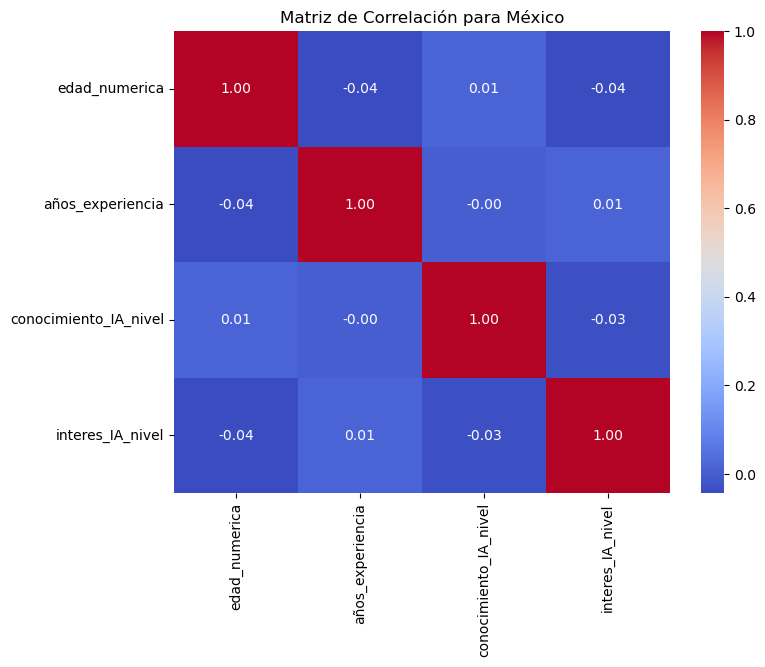


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


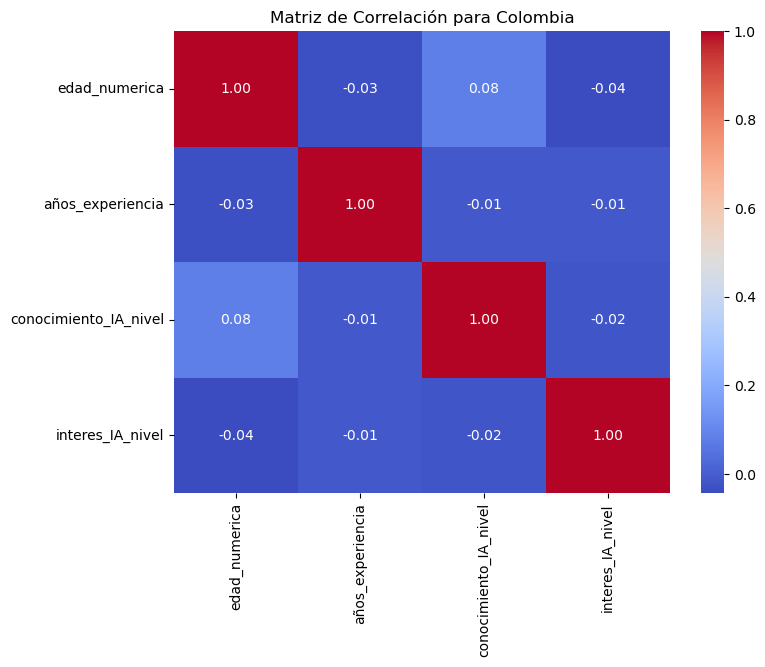


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


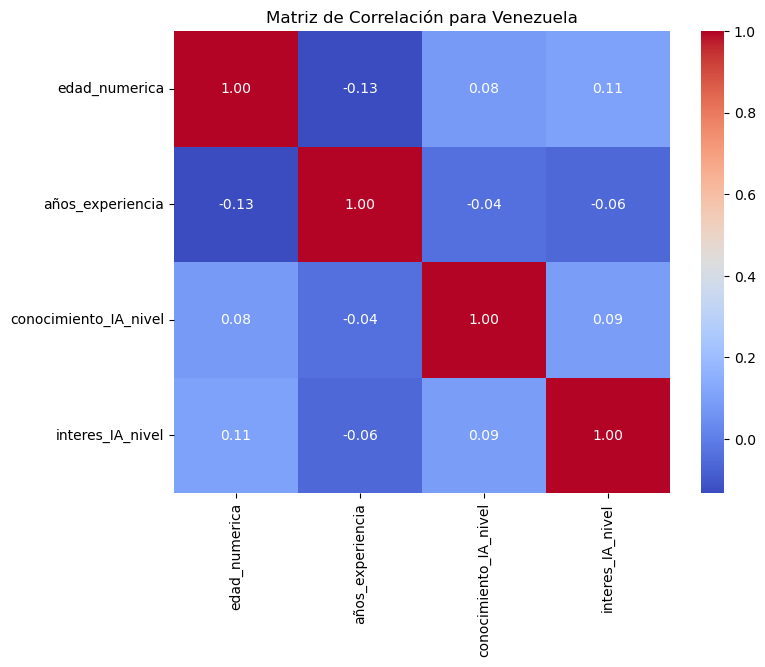



--- Comparaciones de Medias entre Países ---

[ANOVA] Comparando 'conocimiento_IA_nivel' por País:
  - p-valor = 0.8806
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_IA_13' por País:
  - p-valor = 0.1608
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_IA_22' por País:
  - p-valor = 0.5062
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'barrera_IA_29' por País:
  - p-valor = 0.6202
  - No hay una diferencia significativa entre los países en esta variable.

[T-test] para México
  - 'conocimiento_IA_nivel' vs. Género: p-valor = 0.5814
  - 'conocimiento_IA_nivel' vs. Uso de IA: p-valor = 0.7222
  - 'interes_IA_nivel' vs. Género: p-valor = 0.7644
  - 'interes_IA_nivel' vs. Uso de IA: p-valor = 0.1581
  - 'percepcion_IA_13' vs. Género: p-valor = 0.0662
  - 'percepcion_IA_13' vs. Uso de IA: p-valor = 0.3158
  - 'impacto_IA_22' v

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500
paises = ['México', 'Colombia', 'Venezuela']
prob_pais = [0.45, 0.45, 0.1]
np.random.choice(paises, size=n_samples, p=prob_pais)

# --------------------------
# 1. Generación de Datos de la Encuesta Completa
# --------------------------
data = {
    # Sección II: Demográfica y Profesional
    'pais': np.random.choice(paises, size=n_samples, p=prob_pais),
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]),
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]),
    'años_experiencia': np.random.randint(1, 40, size=n_samples),
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]),
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]),
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]),
    
    # Sección III: Adopción y Uso de IA
    'conocimiento_IA_nivel': np.random.randint(1, 6, size=n_samples), # P9
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]),
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección IV: Percepción de la IA (P13-21)
    **{f'percepcion_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(13, 22)},

    # Sección V: Impacto en la Profesión (P22-28)
    **{f'impacto_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(22, 29)},

    # Sección VI: Barreras y Facilitadores (P29-32)
    **{f'barrera_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(29, 33)},
    
    # Sección VII: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P33
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección VIII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples),
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples),
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples),
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples),
}

df = pd.DataFrame(data)

# Mapear rango de edad a valor numérico para correlación
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['edad_numerica', 'años_experiencia', 'conocimiento_IA_nivel', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Países (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Países ---")
variables_anova = ['conocimiento_IA_nivel', 'percepcion_IA_13', 'impacto_IA_22', 'barrera_IA_29']
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

variables_ttest = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'percepcion_IA_13', 'impacto_IA_22']
for pais in paises:
    print(f"\n[T-test] para {pais}")
    df_pais = df[df['pais'] == pais]
    
    for var in variables_ttest:
        hombres = df_pais[df_pais['genero'] == 'Masculino'][var]
        mujeres = df_pais[df_pais['genero'] == 'Femenino'][var]
        if len(hombres) > 1 and len(mujeres) > 1:
            t_stat, p_value = ttest_ind(hombres, mujeres, nan_policy='omit')
            print(f"  - '{var}' vs. Género: p-valor = {p_value:.4f}")

        usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'Si'][var]
        no_usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'No'][var]
        if len(usa_ia) > 1 and len(no_usa_ia) > 1:
            t_stat, p_value = ttest_ind(usa_ia, no_usa_ia, nan_policy='omit')
            print(f"  - '{var}' vs. Uso de IA: p-valor = {p_value:.4f}")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables
# --------------------------

df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define a base list of predictors to be used across all models
base_predictors = ['años_experiencia', 'edad_numerica'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors for this model
predictors_uso_ia = ['conocimiento_IA_nivel', 'interes_IA_nivel'] + base_predictors
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA_nivel' ---")
# Predictors for this model
predictors_conocimiento = ['interes_IA_nivel'] + base_predictors
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA_nivel']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors for this model
predictors_interes = ['conocimiento_IA_nivel'] + base_predictors
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --- Modelo 4: Prediciendo la PERCEPCIÓN DE AUTOMATIZACIÓN (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'percepcion_IA_13' ---")
# Predictors for this model
predictors_percepcion = ['conocimiento_IA_nivel', 'interes_IA_nivel'] + base_predictors
X_percepcion = df_reg[predictors_percepcion].astype(float)
y_percepcion = df_reg['percepcion_IA_13']
X_percepcion = sm.add_constant(X_percepcion)
modelo_lineal_percepcion = sm.OLS(y_percepcion, X_percepcion).fit()
print(modelo_lineal_percepcion.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento por País ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


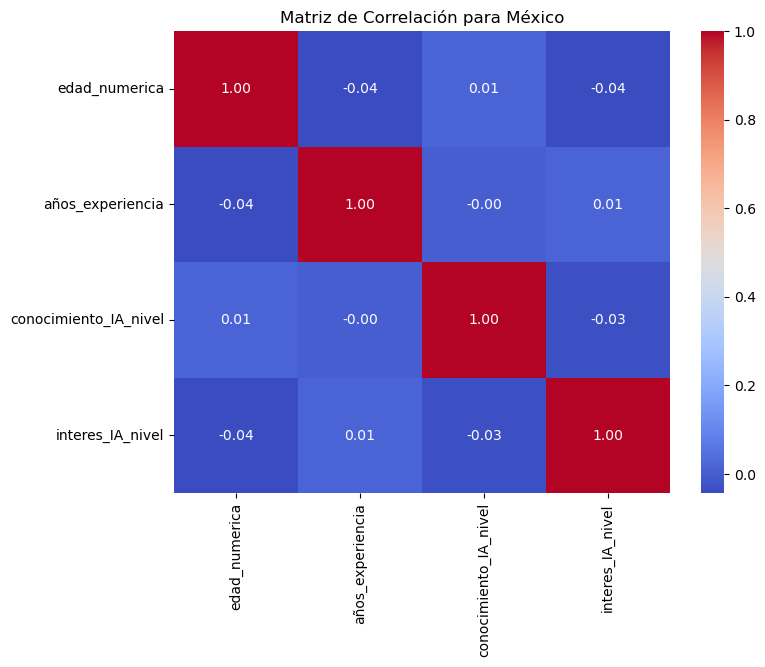


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


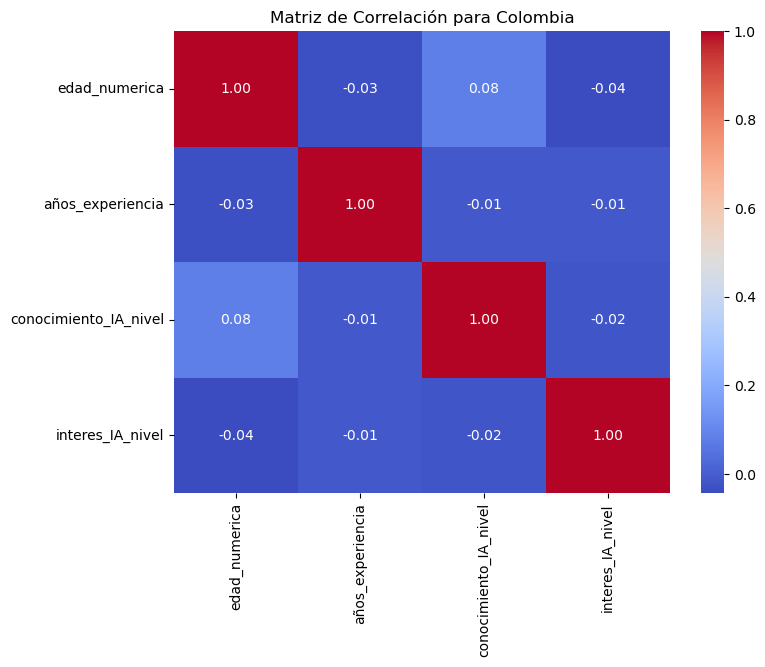


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


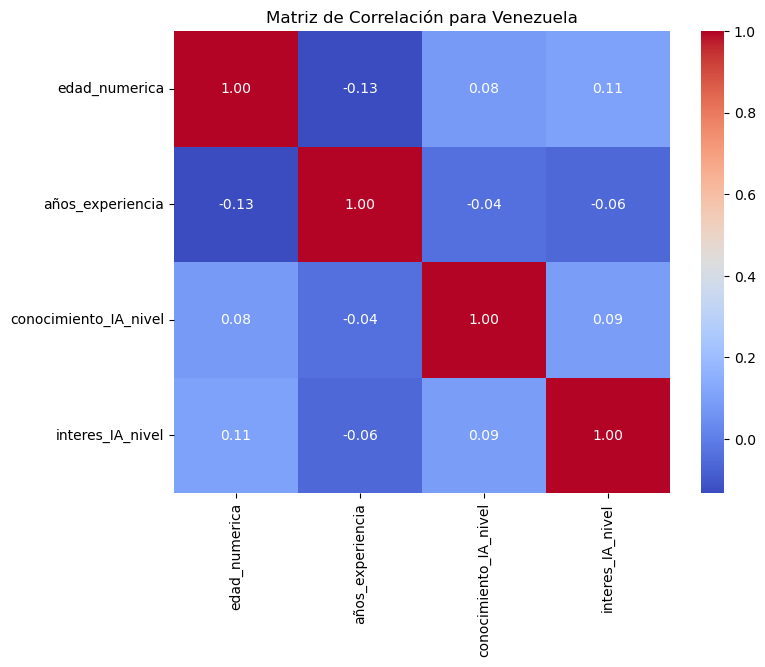



--- Comparaciones de Medias entre Países ---

[ANOVA] Comparando 'conocimiento_IA_nivel' por País:
  - p-valor = 0.8806
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_IA_13' por País:
  - p-valor = 0.1608
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_IA_22' por País:
  - p-valor = 0.5062
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'barrera_IA_29' por País:
  - p-valor = 0.6202
  - No hay una diferencia significativa entre los países en esta variable.

[T-test] para México
  - 'conocimiento_IA_nivel' vs. Género: p-valor = 0.5814
  - 'conocimiento_IA_nivel' vs. Uso de IA: p-valor = 0.7222
  - 'interes_IA_nivel' vs. Género: p-valor = 0.7644
  - 'interes_IA_nivel' vs. Uso de IA: p-valor = 0.1581
  - 'percepcion_IA_13' vs. Género: p-valor = 0.0662
  - 'percepcion_IA_13' vs. Uso de IA: p-valor = 0.3158
  - 'impacto_IA_22' v

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500
paises = ['México', 'Colombia', 'Venezuela']
prob_pais = [0.45, 0.45, 0.1]
np.random.choice(paises, size=n_samples, p=prob_pais)

# --------------------------
# 1. Generación de Datos de la Encuesta Completa
# --------------------------
data = {
    # Sección II: Demográfica y Profesional
    'pais': np.random.choice(paises, size=n_samples, p=prob_pais),
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]),
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]),
    'años_experiencia': np.random.randint(1, 40, size=n_samples),
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]),
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]),
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]),
    
    # Sección III: Adopción y Uso de IA
    'conocimiento_IA_nivel': np.random.randint(1, 6, size=n_samples), # P9
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]),
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]),
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección IV: Percepción de la IA (P13-21)
    **{f'percepcion_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(13, 22)},

    # Sección V: Impacto en la Profesión (P22-28)
    **{f'impacto_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(22, 29)},

    # Sección VI: Barreras y Facilitadores (P29-32)
    **{f'barrera_IA_{i}': np.random.randint(1, 6, size=n_samples) for i in range(29, 33)},
    
    # Sección VII: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P33
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)],

    # Sección VIII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples),
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples),
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples),
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples),
}

df = pd.DataFrame(data)

# Mapear rango de edad a valor numérico para correlación
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['edad_numerica', 'años_experiencia', 'conocimiento_IA_nivel', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Países (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Países ---")
variables_anova = ['conocimiento_IA_nivel', 'percepcion_IA_13', 'impacto_IA_22', 'barrera_IA_29']
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

variables_ttest = ['conocimiento_IA_nivel', 'interes_IA_nivel', 'percepcion_IA_13', 'impacto_IA_22']
for pais in paises:
    print(f"\n[T-test] para {pais}")
    df_pais = df[df['pais'] == pais]
    
    for var in variables_ttest:
        hombres = df_pais[df_pais['genero'] == 'Masculino'][var]
        mujeres = df_pais[df_pais['genero'] == 'Femenino'][var]
        if len(hombres) > 1 and len(mujeres) > 1:
            t_stat, p_value = ttest_ind(hombres, mujeres, nan_policy='omit')
            print(f"  - '{var}' vs. Género: p-valor = {p_value:.4f}")

        usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'Si'][var]
        no_usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'No'][var]
        if len(usa_ia) > 1 and len(no_usa_ia) > 1:
            t_stat, p_value = ttest_ind(usa_ia, no_usa_ia, nan_policy='omit')
            print(f"  - '{var}' vs. Uso de IA: p-valor = {p_value:.4f}")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables
# --------------------------

df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Variables predictoras sin la variable edad_numerica
base_predictors = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors for this model
predictors_uso_ia = ['conocimiento_IA_nivel', 'interes_IA_nivel'] + base_predictors
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA_nivel' ---")
# Predictors for this model
predictors_conocimiento = ['interes_IA_nivel'] + base_predictors
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA_nivel']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors for this model
predictors_interes = ['conocimiento_IA_nivel'] + base_predictors
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --- Modelo 4: Prediciendo la PERCEPCIÓN DE AUTOMATIZACIÓN (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'percepcion_IA_13' ---")
# Predictors for this model
predictors_percepcion = ['conocimiento_IA_nivel', 'interes_IA_nivel'] + base_predictors
X_percepcion = df_reg[predictors_percepcion].astype(float)
y_percepcion = df_reg['percepcion_IA_13']
X_percepcion = sm.add_constant(X_percepcion)
modelo_lineal_percepcion = sm.OLS(y_percepcion, X_percepcion).fit()
print(modelo_lineal_percepcion.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento por País ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


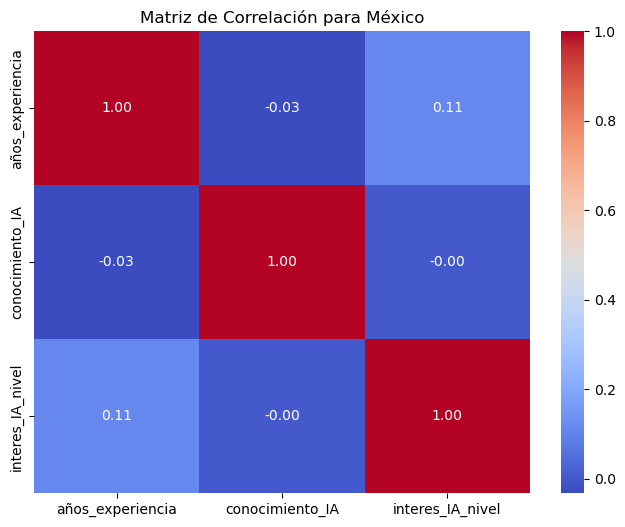


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


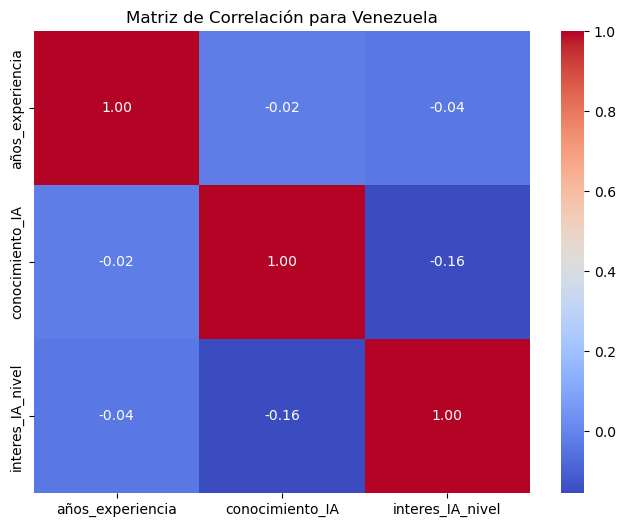


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


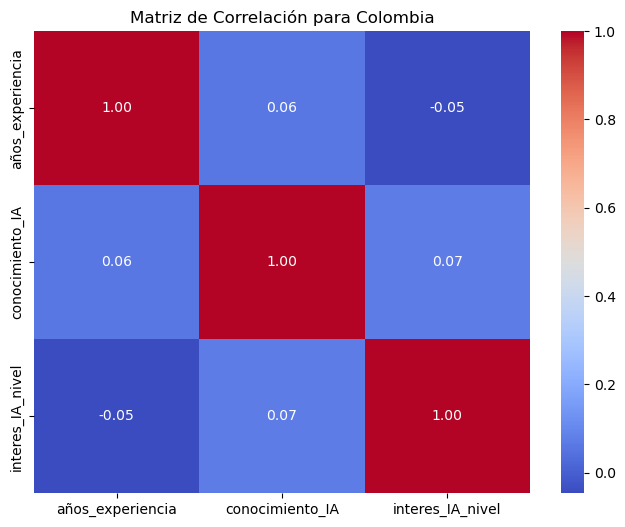



--- Comparaciones de Medias entre Países ---

[ANOVA] Comparando 'conocimiento_IA' por País:
  - p-valor = 0.9782
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_automatizacion' por País:
  - p-valor = 0.9745
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_habilidades_analiticas' por País:
  - p-valor = 0.9252
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'barrera_costo' por País:
  - p-valor = 0.1617
  - No hay una diferencia significativa entre los países en esta variable.

[T-test] para México
  - 'conocimiento_IA' vs. Género: p-valor = 0.3353
  - 'conocimiento_IA' vs. Uso de IA: p-valor = 0.3925
  - 'interes_IA_nivel' vs. Género: p-valor = 0.9383
  - 'interes_IA_nivel' vs. Uso de IA: p-valor = 0.2968
  - 'percepcion_automatizacion' vs. Género: p-valor = 0.3894
  - 'percepcion_automatizacion' vs. Uso de IA: p-valor = 0.

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['años_experiencia', 'conocimiento_IA', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Países (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Países ---")
variables_anova = ['conocimiento_IA', 'percepcion_automatizacion', 'impacto_habilidades_analiticas', 'barrera_costo']
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

variables_ttest = ['conocimiento_IA', 'interes_IA_nivel', 'percepcion_automatizacion', 'impacto_habilidades_analiticas']
for pais in paises:
    print(f"\n[T-test] para {pais}")
    df_pais = df[df['pais'] == pais]
    
    for var in variables_ttest:
        hombres = df_pais[df_pais['genero'] == 'Masculino'][var]
        mujeres = df_pais[df_pais['genero'] == 'Femenino'][var]
        if len(hombres) > 1 and len(mujeres) > 1:
            t_stat, p_value = ttest_ind(hombres, mujeres, nan_policy='omit')
            print(f"  - '{var}' vs. Género: p-valor = {p_value:.4f}")

        usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'Si'][var]
        no_usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'No'][var]
        if len(usa_ia) > 1 and len(no_usa_ia) > 1:
            t_stat, p_value = ttest_ind(usa_ia, no_usa_ia, nan_policy='omit')
            print(f"  - '{var}' vs. Uso de IA: p-valor = {p_value:.4f}")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables
# --------------------------

df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define una lista base de predictores demográficos y profesionales
base_predictors = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors: conocimiento_IA, interes_IA_nivel + base
predictors_uso_ia = ['conocimiento_IA', 'interes_IA_nivel'] + base_predictors
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA' ---")
# Predictors: interes_IA_nivel + base
predictors_conocimiento = ['interes_IA_nivel'] + base_predictors
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors: conocimiento_IA + base
predictors_interes = ['conocimiento_IA'] + base_predictors
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --- Modelo 4: Prediciendo la PERCEPCIÓN DE LA AUTOMATIZACIÓN (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'percepcion_automatizacion' ---")
# Predictors: conocimiento_IA, interes_IA_nivel + base
predictors_percepcion = ['conocimiento_IA', 'interes_IA_nivel'] + base_predictors
X_percepcion = df_reg[predictors_percepcion].astype(float)
y_percepcion = df_reg['percepcion_automatizacion']
X_percepcion = sm.add_constant(X_percepcion)
modelo_lineal_percepcion = sm.OLS(y_percepcion, X_percepcion).fit()
print(modelo_lineal_percepcion.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento de Respuestas Abiertas ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


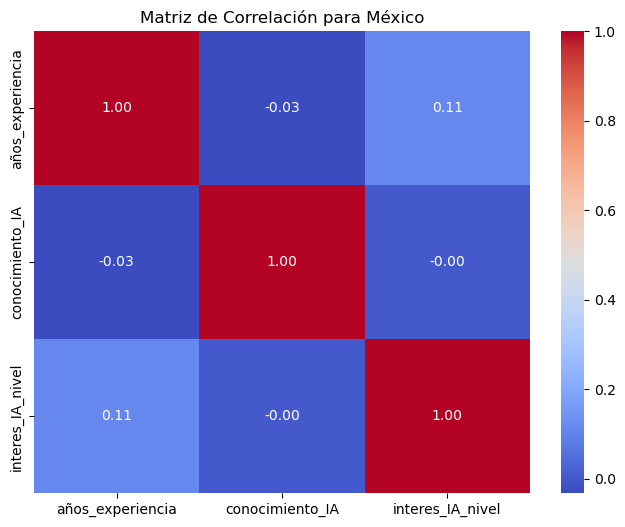


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


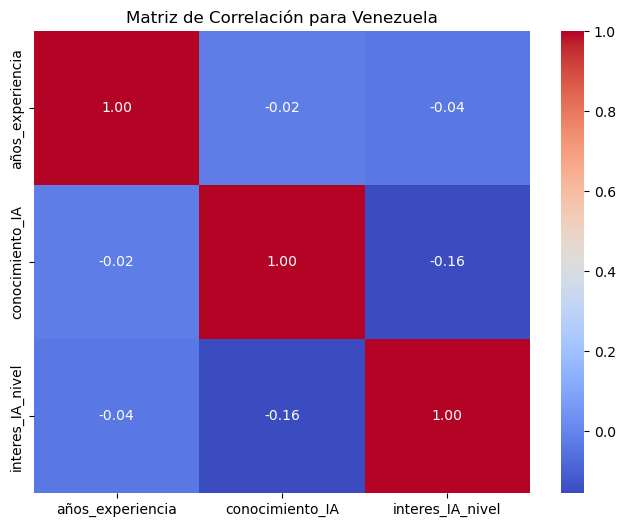


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


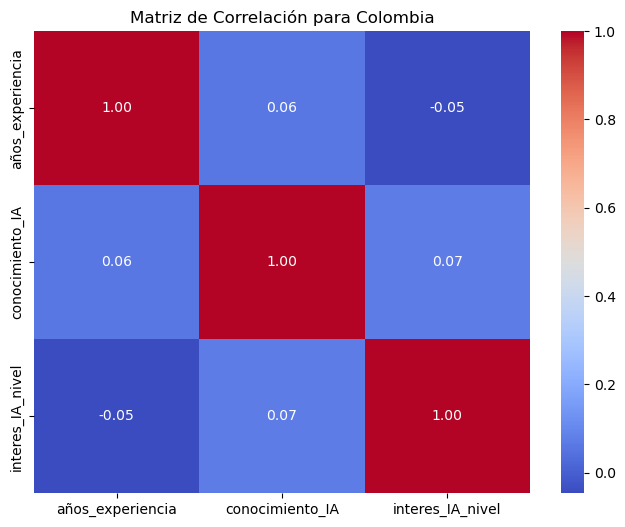



--- Comparaciones de Medias entre Grupos ---

[ANOVA] Comparando 'conocimiento_IA' por País:
  - p-valor = 0.9782
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'interes_IA_nivel' por País:
  - p-valor = 0.5041
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_automatizacion' por País:
  - p-valor = 0.9745
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_eficiencia' por País:
  - p-valor = 0.4846
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_riesgo_ciberseguridad' por País:
  - p-valor = 0.0634
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_habilidades_analiticas' por País:
  - p-valor = 0.9252
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_formacion_c

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Relaciones entre variables numéricas (Correlación)
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = ['años_experiencia', 'conocimiento_IA', 'interes_IA_nivel']
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Grupos (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Grupos ---")
# Ampliación de variables para ANOVA por país
variables_anova = [
    'conocimiento_IA', 'interes_IA_nivel',
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_riesgo_ciberseguridad',
    'impacto_habilidades_analiticas', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

# Ampliación de variables y grupos para T-tests
variables_ttest = [
    'conocimiento_IA', 'interes_IA_nivel', 'percepcion_automatizacion',
    'impacto_habilidades_analiticas', 'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_ttest:
    # T-test por Género
    hombres = df[df['genero'] == 'Masculino'][var]
    mujeres = df[df['genero'] == 'Femenino'][var]
    if len(hombres) > 1 and len(mujeres) > 1:
        t_stat, p_value = ttest_ind(hombres, mujeres, nan_policy='omit')
        print(f"  - T-test: '{var}' vs. Género (p={p_value:.4f})")

    # T-test por Uso de IA
    usa_ia = df[df['uso_herramientas_IA_cat'] == 'Si'][var]
    no_usa_ia = df[df['uso_herramientas_IA_cat'] == 'No'][var]
    if len(usa_ia) > 1 and len(no_usa_ia) > 1:
        t_stat, p_value = ttest_ind(usa_ia, no_usa_ia, nan_policy='omit')
        print(f"  - T-test: '{var}' vs. Uso de IA (p={p_value:.4f})")

    # T-test por Tipo de Organización (Empresa privada vs. Firma de contabilidad)
    privada = df[df['tipo_organizacion'] == 'Empresa privada'][var]
    firma = df[df['tipo_organizacion'] == 'Firma de contabilidad'][var]
    if len(privada) > 1 and len(firma) > 1:
        t_stat, p_value = ttest_ind(privada, firma, nan_policy='omit')
        print(f"  - T-test: '{var}' vs. Tipo de Organización (p={p_value:.4f})")


# --------------------------
# 4. Análisis de Regresión para Múltiples Variables (Modelos más robustos)
# --------------------------
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define una lista base de predictores demográficos y profesionales
base_demograficos_profesionales = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# Define una lista de todas las variables de percepción, impacto y barreras
variables_percepcion_impacto_barrera = [
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_precisión',
    'percepcion_riesgo_ciberseguridad', 'percepcion_riesgo_sesgo', 'percepcion_reemplazo_rol',
    'percepcion_mejorar_asesoramiento', 'percepcion_inversion_necesaria', 'percepcion_facil_implementacion',
    'impacto_habilidades_analiticas', 'impacto_habilidades_sociales', 'impacto_cambio_funciones',
    'impacto_creacion_nuevos_roles', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'impacto_etica_profesional',
    'barrera_conocimiento_falta', 'barrera_costo', 'barrera_resistencia_cambio', 'barrera_regulacion'
]

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors: Conocimiento, Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_uso_ia = ['conocimiento_IA', 'interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA' ---")
# Predictors: Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_conocimiento = ['interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors: Conocimiento, Percepciones, Impactos, Barreras, Demográficos
predictors_interes = ['conocimiento_IA'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento de Respuestas Abiertas ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


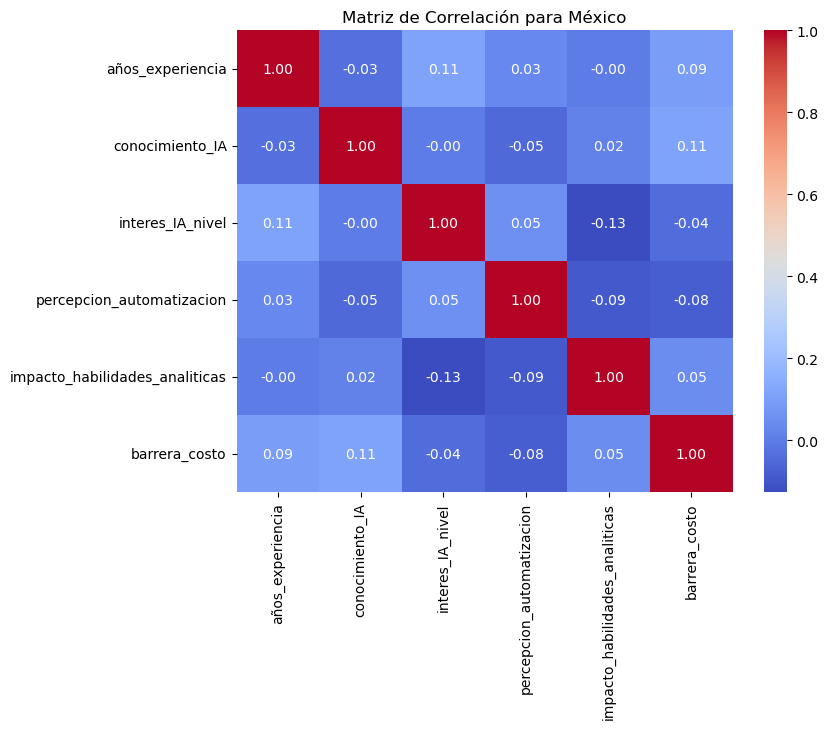


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


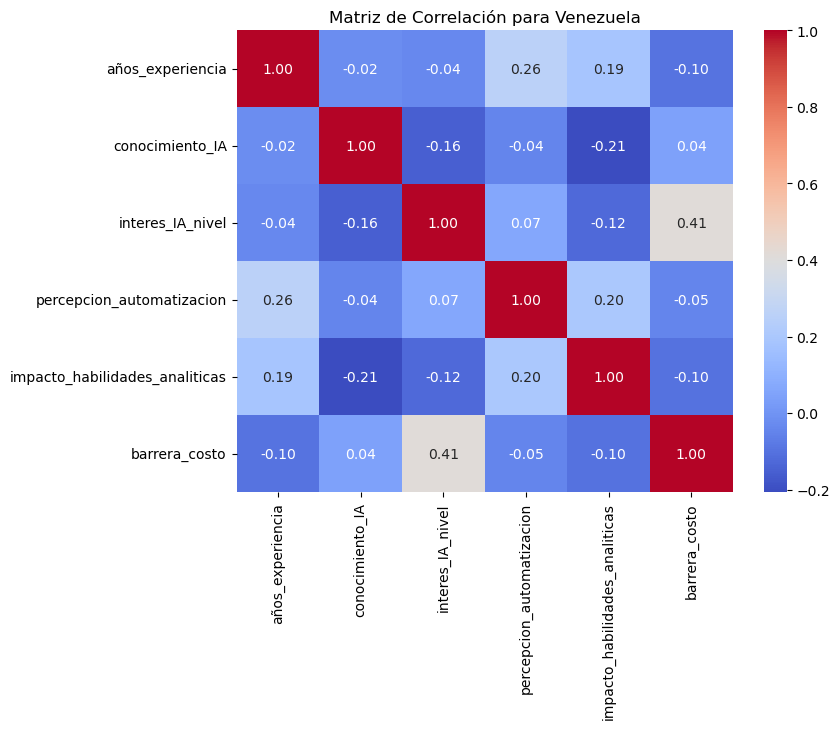


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


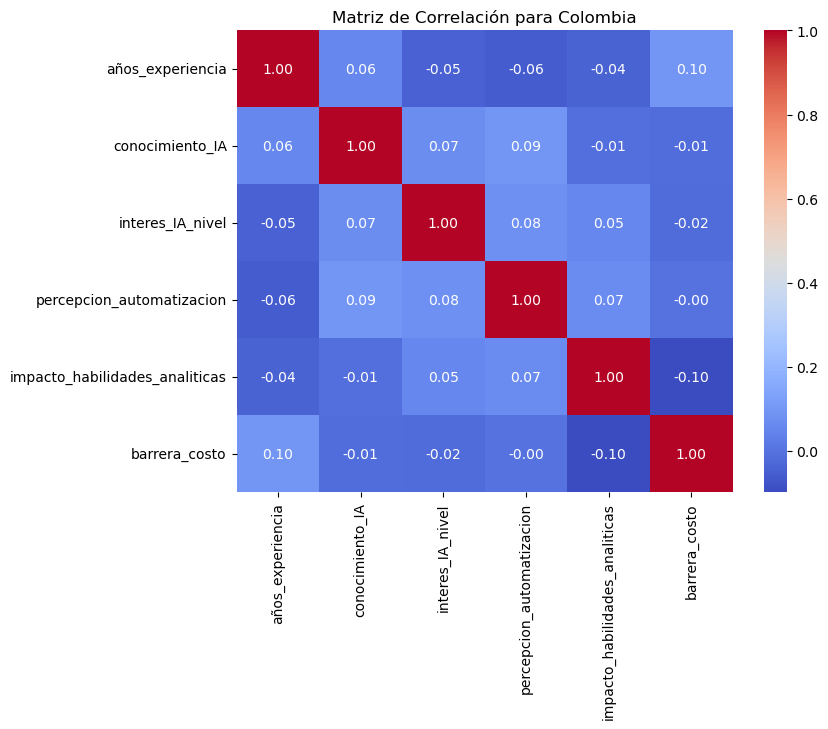



--- Comparaciones de Medias entre Grupos ---

[ANOVA] Comparando 'conocimiento_IA' por País:
  - p-valor = 0.9782
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'interes_IA_nivel' por País:
  - p-valor = 0.5041
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_automatizacion' por País:
  - p-valor = 0.9745
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_eficiencia' por País:
  - p-valor = 0.4846
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_riesgo_ciberseguridad' por País:
  - p-valor = 0.0634
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_habilidades_analiticas' por País:
  - p-valor = 0.9252
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_formacion_c

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Ampliación de las variables para la Matriz de Correlación
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = [
        'años_experiencia', 'conocimiento_IA', 'interes_IA_nivel',
        'percepcion_automatizacion', 'impacto_habilidades_analiticas', 'barrera_costo'
    ]
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Grupos (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Grupos ---")
# Ampliación de variables para ANOVA por país
variables_anova = [
    'conocimiento_IA', 'interes_IA_nivel',
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_riesgo_ciberseguridad',
    'impacto_habilidades_analiticas', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

# Ampliación de variables y grupos para T-tests
variables_ttest = [
    'conocimiento_IA', 'interes_IA_nivel', 'percepcion_automatizacion',
    'impacto_habilidades_analiticas', 'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_ttest:
    # T-test por Género
    hombres = df[df['genero'] == 'Masculino'][var]
    mujeres = df[df['genero'] == 'Femenino'][var]
    if len(hombres) > 1 and len(mujeres) > 1:
        t_stat, p_value = ttest_ind(hombres, mujeres, nan_policy='omit')
        print(f"  - T-test: '{var}' vs. Género (p={p_value:.4f})")

    # T-test por Uso de IA
    usa_ia = df[df['uso_herramientas_IA_cat'] == 'Si'][var]
    no_usa_ia = df[df['uso_herramientas_IA_cat'] == 'No'][var]
    if len(usa_ia) > 1 and len(no_usa_ia) > 1:
        t_stat, p_value = ttest_ind(usa_ia, no_usa_ia, nan_policy='omit')
        print(f"  - T-test: '{var}' vs. Uso de IA (p={p_value:.4f})")

    # T-test por Tipo de Organización (Empresa privada vs. Firma de contabilidad)
    privada = df[df['tipo_organizacion'] == 'Empresa privada'][var]
    firma = df[df['tipo_organizacion'] == 'Firma de contabilidad'][var]
    if len(privada) > 1 and len(firma) > 1:
        t_stat, p_value = ttest_ind(privada, firma, nan_policy='omit')
        print(f"  - T-test: '{var}' vs. Tipo de Organización (p={p_value:.4f})")


# --------------------------
# 4. Análisis de Regresión para Múltiples Variables (Modelos más robustos)
# --------------------------
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define una lista base de predictores demográficos y profesionales
base_demograficos_profesionales = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# Define una lista de todas las variables de percepción, impacto y barreras
variables_percepcion_impacto_barrera = [
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_precisión',
    'percepcion_riesgo_ciberseguridad', 'percepcion_riesgo_sesgo', 'percepcion_reemplazo_rol',
    'percepcion_mejorar_asesoramiento', 'percepcion_inversion_necesaria', 'percepcion_facil_implementacion',
    'impacto_habilidades_analiticas', 'impacto_habilidades_sociales', 'impacto_cambio_funciones',
    'impacto_creacion_nuevos_roles', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'impacto_etica_profesional',
    'barrera_conocimiento_falta', 'barrera_costo', 'barrera_resistencia_cambio', 'barrera_regulacion'
]

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors: Conocimiento, Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_uso_ia = ['conocimiento_IA', 'interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA' ---")
# Predictors: Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_conocimiento = ['interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors: Conocimiento, Percepciones, Impactos, Barreras, Demográficos
predictors_interes = ['conocimiento_IA'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento de Respuestas Abiertas ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


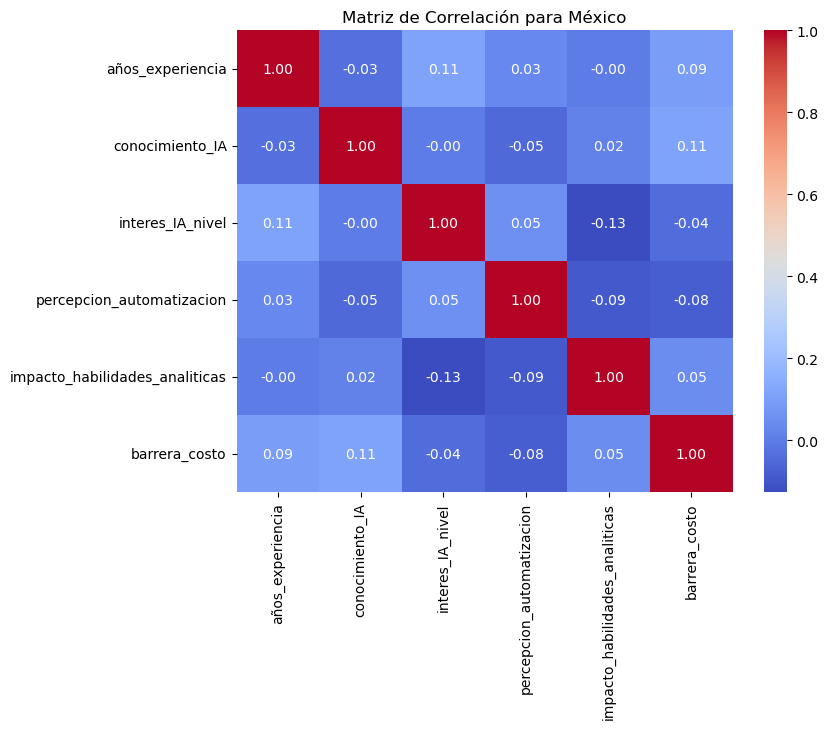


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


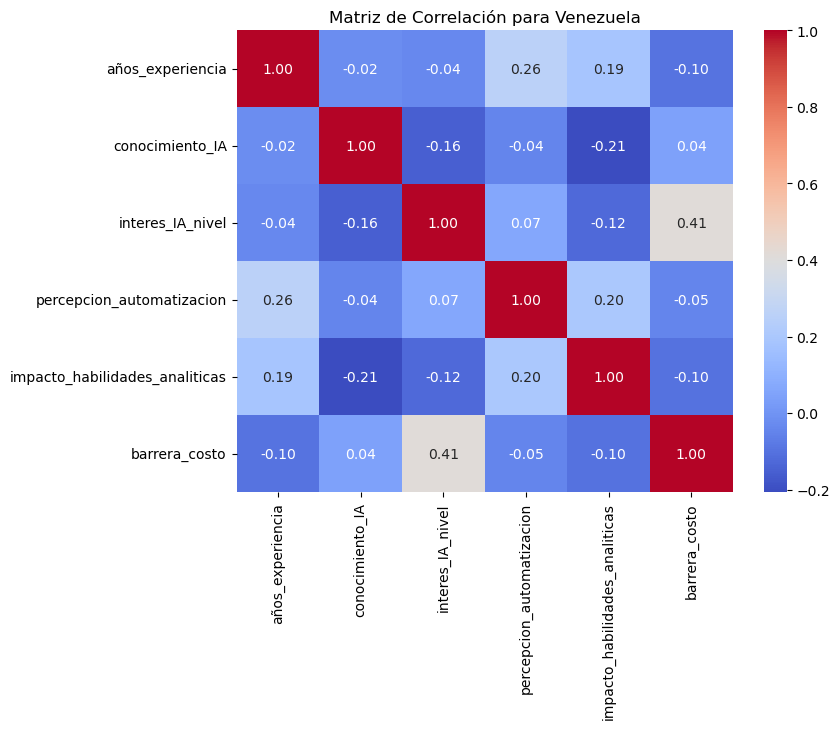


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


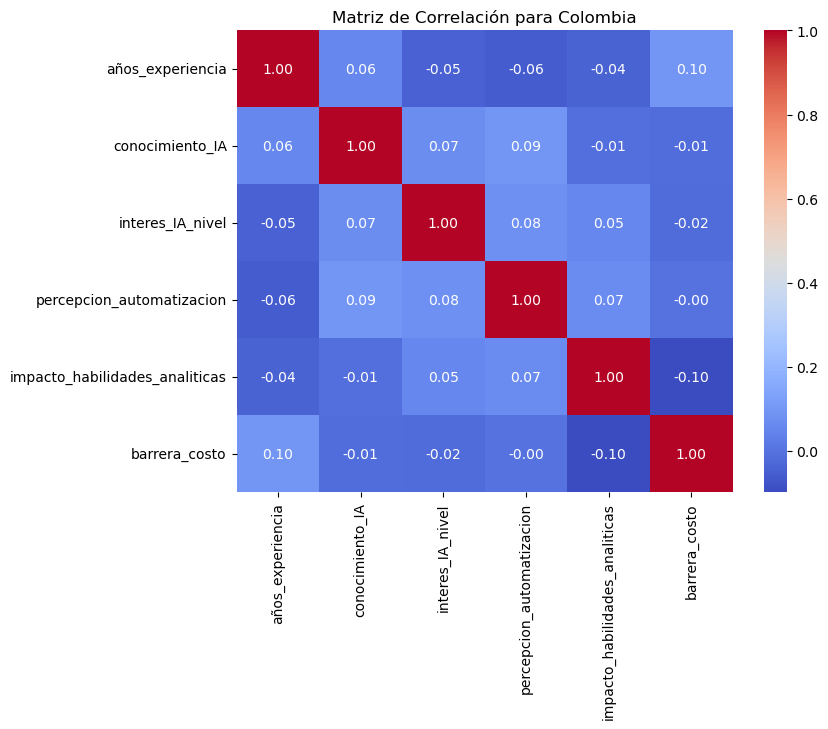



--- Comparaciones de Medias entre Grupos ---


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Ampliación de las variables para la Matriz de Correlación
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = [
        'años_experiencia', 'conocimiento_IA', 'interes_IA_nivel',
        'percepcion_automatizacion', 'impacto_habilidades_analiticas', 'barrera_costo'
    ]
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Grupos (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Grupos ---")
# Ampliación de variables para ANOVA por país
variables_anova = [
    'conocimiento_IA', 'interes_IA_nivel',
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_riesgo_ciberseguridad',
    'impacto_habilidades_analiticas', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


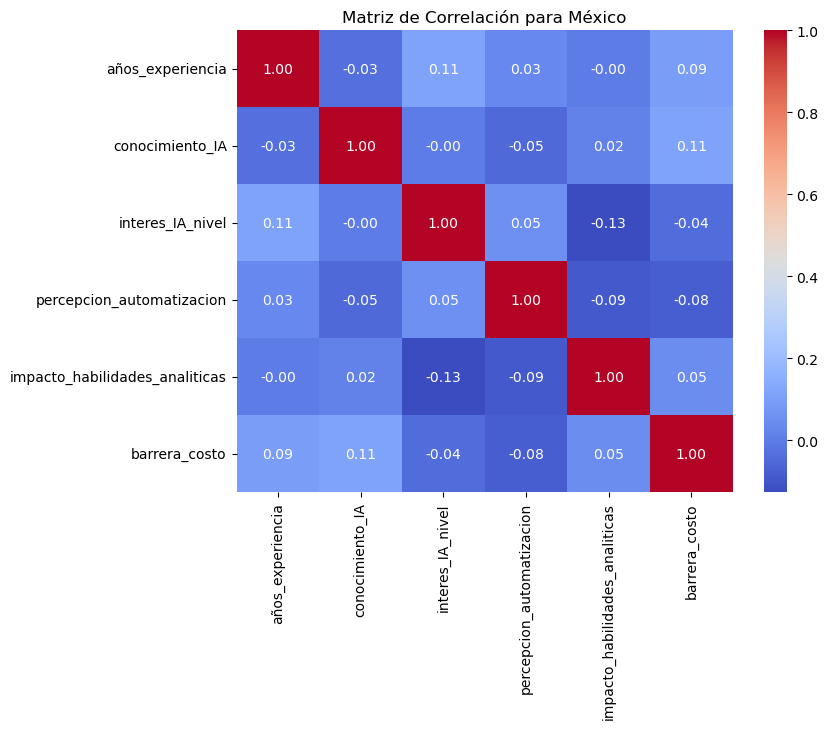


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


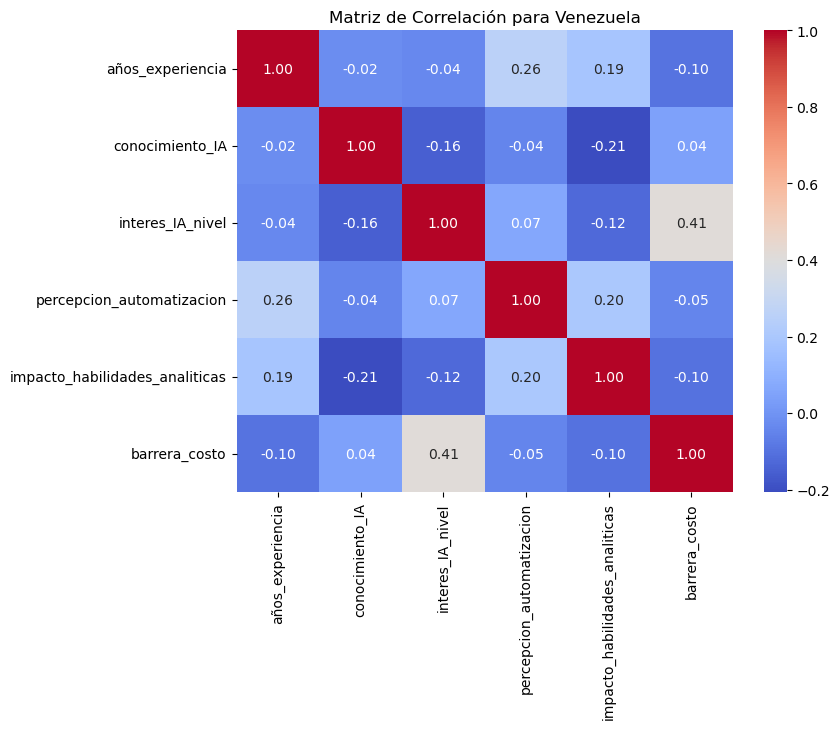


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


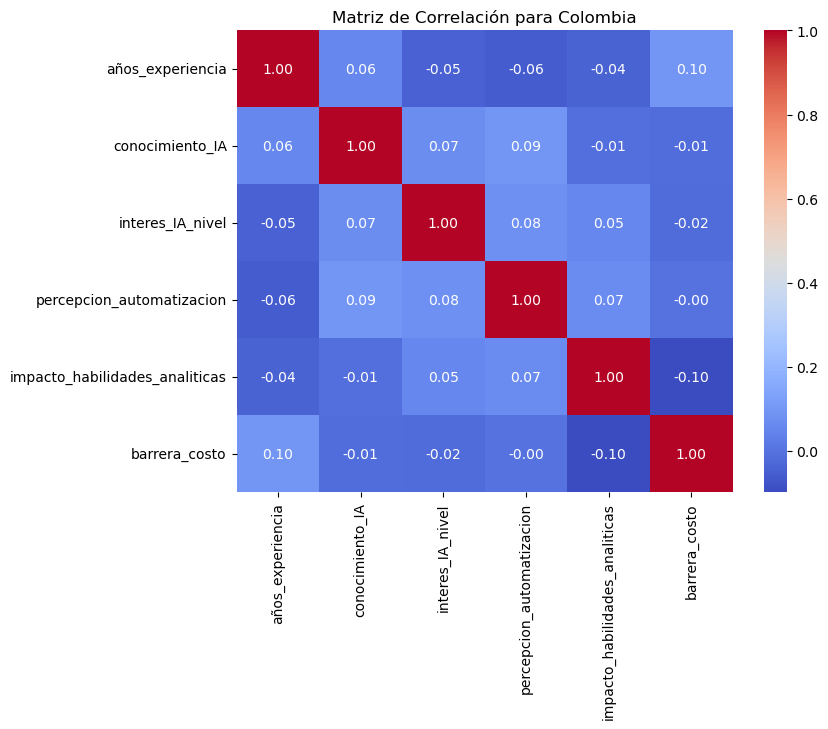



--- Comparaciones de Medias entre Grupos ---

[ANOVA] Comparando 'conocimiento_IA' por País:
  - p-valor = 0.9782
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'interes_IA_nivel' por País:
  - p-valor = 0.5041
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_automatizacion' por País:
  - p-valor = 0.9745
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_eficiencia' por País:
  - p-valor = 0.4846
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_riesgo_ciberseguridad' por País:
  - p-valor = 0.0634
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_habilidades_analiticas' por País:
  - p-valor = 0.9252
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_formacion_c

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Ampliación de las variables para la Matriz de Correlación
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = [
        'años_experiencia', 'conocimiento_IA', 'interes_IA_nivel',
        'percepcion_automatizacion', 'impacto_habilidades_analiticas', 'barrera_costo'
    ]
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Grupos (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Grupos ---")
# Ampliación de variables para ANOVA por país
variables_anova = [
    'conocimiento_IA', 'interes_IA_nivel',
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_riesgo_ciberseguridad',
    'impacto_habilidades_analiticas', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

# Ampliación de variables y grupos para T-tests
print("\n\n--- T-tests por País ---")
variables_ttest = [
    'conocimiento_IA', 'interes_IA_nivel', 'percepcion_automatizacion',
    'impacto_habilidades_analiticas', 'barrera_costo', 'barrera_resistencia_cambio'
]

# El bucle por país ahora contiene los T-tests
for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n======== {pais.upper()} ========")
    for var in variables_ttest:
        # T-test por Género
        hombres = df_pais[df_pais['genero'] == 'Masculino'][var]
        mujeres = df_pais[df_pais['genero'] == 'Femenino'][var]
        if len(hombres) > 1 and len(mujeres) > 1:
            t_stat, p_value = ttest_ind(hombres, mujeres, nan_policy='omit')
            print(f"  - T-test: '{var}' vs. Género (p={p_value:.4f})")

        # T-test por Uso de IA
        usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'Si'][var]
        no_usa_ia = df_pais[df_pais['uso_herramientas_IA_cat'] == 'No'][var]
        if len(usa_ia) > 1 and len(no_usa_ia) > 1:
            t_stat, p_value = ttest_ind(usa_ia, no_usa_ia, nan_policy='omit')
            print(f"  - T-test: '{var}' vs. Uso de IA (p={p_value:.4f})")

        # T-test por Tipo de Organización (Empresa privada vs. Firma de contabilidad)
        privada = df_pais[df_pais['tipo_organizacion'] == 'Empresa privada'][var]
        firma = df_pais[df_pais['tipo_organizacion'] == 'Firma de contabilidad'][var]
        if len(privada) > 1 and len(firma) > 1:
            t_stat, p_value = ttest_ind(privada, firma, nan_policy='omit')
            print(f"  - T-test: '{var}' vs. Tipo de Organización (p={p_value:.4f})")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables (Modelos más robustos)
# --------------------------
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define una lista base de predictores demográficos y profesionales
base_demograficos_profesionales = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# Define una lista de todas las variables de percepción, impacto y barreras
variables_percepcion_impacto_barrera = [
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_precisión',
    'percepcion_riesgo_ciberseguridad', 'percepcion_riesgo_sesgo', 'percepcion_reemplazo_rol',
    'percepcion_mejorar_asesoramiento', 'percepcion_inversion_necesaria', 'percepcion_facil_implementacion',
    'impacto_habilidades_analiticas', 'impacto_habilidades_sociales', 'impacto_cambio_funciones',
    'impacto_creacion_nuevos_roles', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'impacto_etica_profesional',
    'barrera_conocimiento_falta', 'barrera_costo', 'barrera_resistencia_cambio', 'barrera_regulacion'
]

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors: Conocimiento, Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_uso_ia = ['conocimiento_IA', 'interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA' ---")
# Predictors: Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_conocimiento = ['interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors: Conocimiento, Percepciones, Impactos, Barreras, Demográficos
predictors_interes = ['conocimiento_IA'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento de Respuestas Abiertas ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


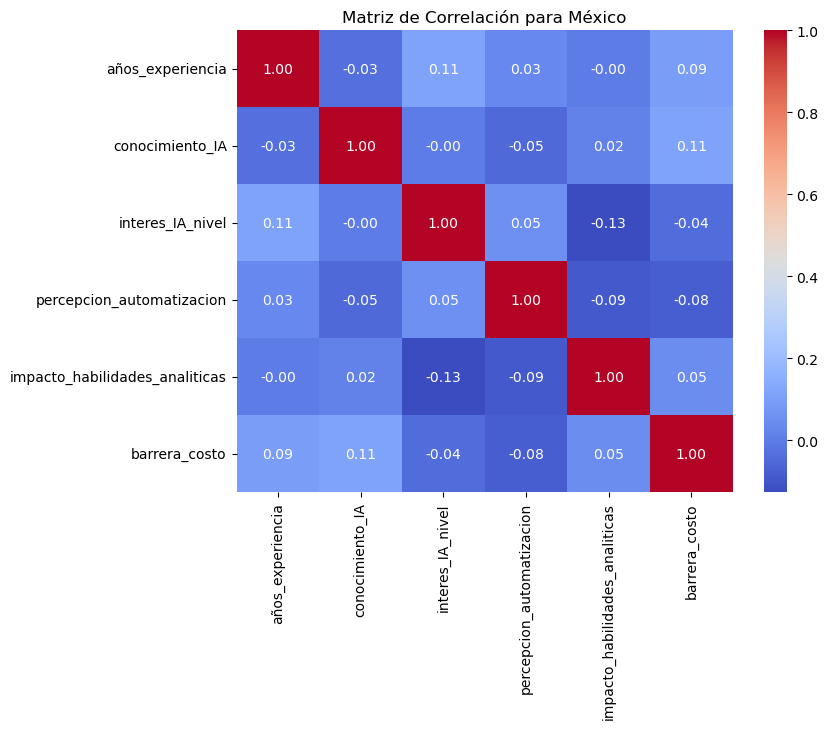


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


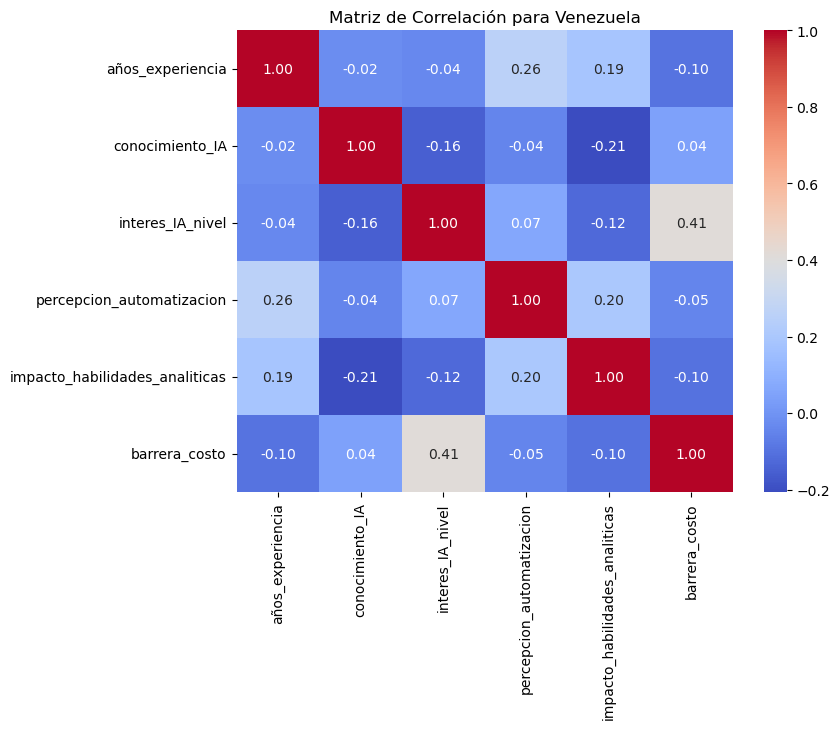


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


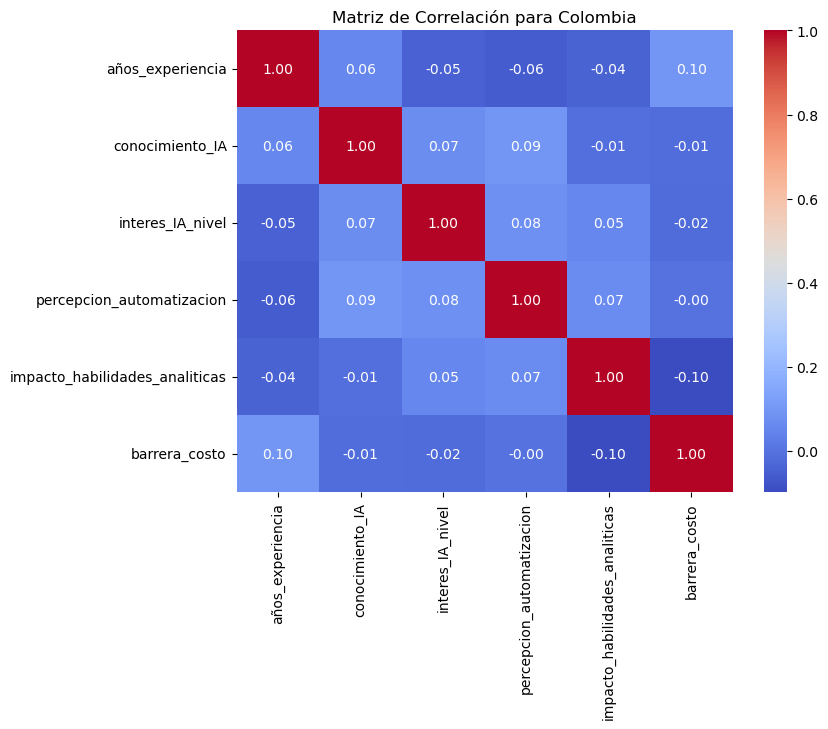



--- Comparaciones de Medias entre Grupos ---

[ANOVA] Comparando 'conocimiento_IA' por País:
  - p-valor = 0.9782
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'interes_IA_nivel' por País:
  - p-valor = 0.5041
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_automatizacion' por País:
  - p-valor = 0.9745
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_eficiencia' por País:
  - p-valor = 0.4846
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_riesgo_ciberseguridad' por País:
  - p-valor = 0.0634
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_habilidades_analiticas' por País:
  - p-valor = 0.9252
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_formacion_c

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Ampliación de las variables para la Matriz de Correlación
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = [
        'años_experiencia', 'conocimiento_IA', 'interes_IA_nivel',
        'percepcion_automatizacion', 'impacto_habilidades_analiticas', 'barrera_costo'
    ]
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Grupos (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Grupos ---")
# Ampliación de variables para ANOVA por país
variables_anova = [
    'conocimiento_IA', 'interes_IA_nivel',
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_riesgo_ciberseguridad',
    'impacto_habilidades_analiticas', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

# Ampliación de variables y grupos para T-tests
print("\n\n--- T-tests por País ---")
variables_ttest = [
    'conocimiento_IA', 'interes_IA_nivel', 'percepcion_automatizacion',
    'impacto_habilidades_analiticas', 'barrera_costo', 'barrera_resistencia_cambio'
]

# El bucle por país ahora contiene los T-tests
for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n======== {pais.upper()} ========")
    
    # Lista de pares de variables y grupos para comparar
    comparaciones = [
        ('genero', 'Masculino', 'Femenino'),
        ('uso_herramientas_IA_cat', 'Si', 'No'),
        ('tipo_organizacion', 'Empresa privada', 'Firma de contabilidad')
    ]

    for var in variables_ttest:
        for group_var, group1_val, group2_val in comparaciones:
            grupo1 = df_pais[df_pais[group_var] == group1_val][var]
            grupo2 = df_pais[df_pais[group_var] == group2_val][var]

            if len(grupo1) > 1 and len(grupo2) > 1:
                t_stat, p_value = ttest_ind(grupo1, grupo2, nan_policy='omit')
                print(f"  - T-test: '{var}' vs. '{group_var}' ({group1_val} vs {group2_val}) (p={p_value:.4f})")

                # Analizar y mostrar las medias solo si el resultado es significativo
                if p_value < 0.05:
                    media_grupo1 = grupo1.mean()
                    media_grupo2 = grupo2.mean()
                    print(f"    - Media de '{group1_val}': {media_grupo1:.2f}")
                    print(f"    - Media de '{group2_val}': {media_grupo2:.2f}")

                    if media_grupo1 > media_grupo2:
                        print(f"    - Conclusión: El grupo '{group1_val}' tiene un valor medio más alto.")
                    else:
                        print(f"    - Conclusión: El grupo '{group2_val}' tiene un valor medio más alto.")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables (Modelos más robustos)
# --------------------------
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define una lista base de predictores demográficos y profesionales
base_demograficos_profesionales = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# Define una lista de todas las variables de percepción, impacto y barreras
variables_percepcion_impacto_barrera = [
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_precisión',
    'percepcion_riesgo_ciberseguridad', 'percepcion_riesgo_sesgo', 'percepcion_reemplazo_rol',
    'percepcion_mejorar_asesoramiento', 'percepcion_inversion_necesaria', 'percepcion_facil_implementacion',
    'impacto_habilidades_analiticas', 'impacto_habilidades_sociales', 'impacto_cambio_funciones',
    'impacto_creacion_nuevos_roles', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'impacto_etica_profesional',
    'barrera_conocimiento_falta', 'barrera_costo', 'barrera_resistencia_cambio', 'barrera_regulacion'
]

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors: Conocimiento, Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_uso_ia = ['conocimiento_IA', 'interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA' ---")
# Predictors: Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_conocimiento = ['interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors: Conocimiento, Percepciones, Impactos, Barreras, Demográficos
predictors_interes = ['conocimiento_IA'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento de Respuestas Abiertas ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


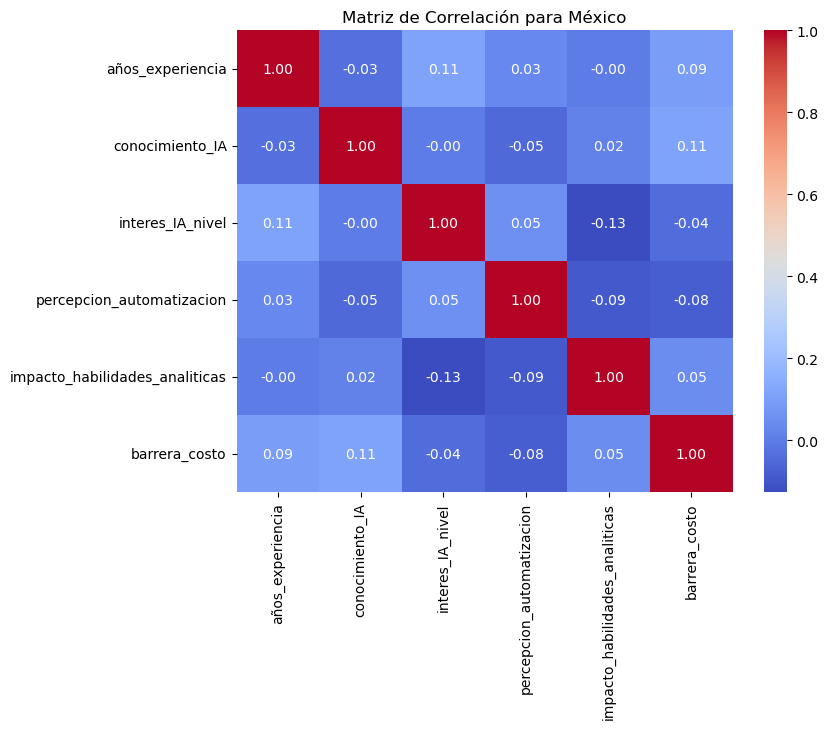


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


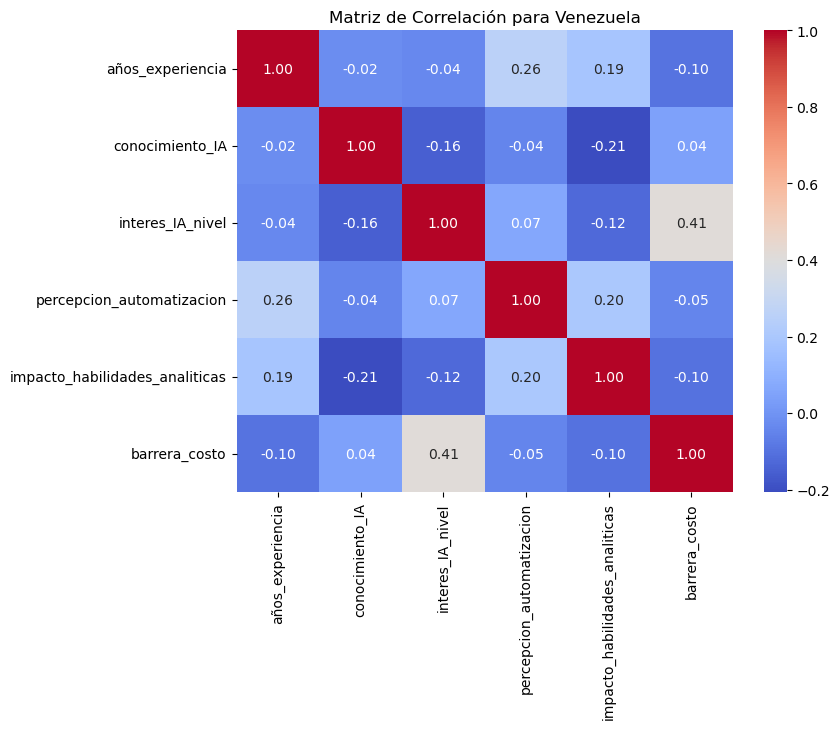


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


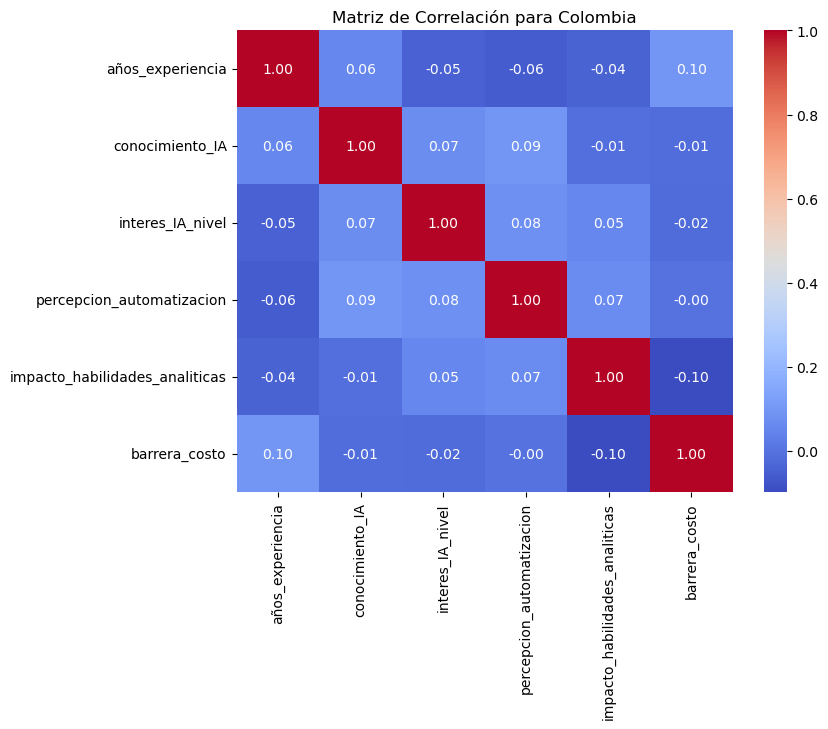



--- Comparaciones de Medias entre Grupos ---

[ANOVA] Comparando 'conocimiento_IA' por País:
  - p-valor = 0.9782
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'interes_IA_nivel' por País:
  - p-valor = 0.5041
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_automatizacion' por País:
  - p-valor = 0.9745
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_eficiencia' por País:
  - p-valor = 0.4846
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_riesgo_ciberseguridad' por País:
  - p-valor = 0.0634
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_habilidades_analiticas' por País:
  - p-valor = 0.9252
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_formacion_c

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Ampliación de las variables para la Matriz de Correlación
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = [
        'años_experiencia', 'conocimiento_IA', 'interes_IA_nivel',
        'percepcion_automatizacion', 'impacto_habilidades_analiticas', 'barrera_costo'
    ]
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Grupos (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Grupos ---")
# Ampliación de variables para ANOVA por país
variables_anova = [
    'conocimiento_IA', 'interes_IA_nivel',
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_riesgo_ciberseguridad',
    'impacto_habilidades_analiticas', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

# Ampliación de variables y grupos para T-tests
print("\n\n--- T-tests por País ---")
variables_ttest = [
    'conocimiento_IA', 'interes_IA_nivel', 'percepcion_automatizacion',
    'impacto_habilidades_analiticas', 'barrera_costo', 'barrera_resistencia_cambio'
]

# El bucle por país ahora contiene los T-tests
for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n======== {pais.upper()} ========")
    
    # Lista de pares de variables y grupos para comparar
    comparaciones = [
        ('genero', 'Masculino', 'Femenino'),
        ('uso_herramientas_IA_cat', 'Si', 'No'),
        ('tipo_organizacion', 'Empresa privada', 'Firma de contabilidad')
    ]

    for var in variables_ttest:
        for group_var, group1_val, group2_val in comparaciones:
            grupo1 = df_pais[df_pais[group_var] == group1_val][var]
            grupo2 = df_pais[df_pais[group_var] == group2_val][var]

            if len(grupo1) > 1 and len(grupo2) > 1:
                t_stat, p_value = ttest_ind(grupo1, grupo2, nan_policy='omit')
                print(f"  - T-test: '{var}' vs. '{group_var}' ({group1_val} vs {group2_val}) (p={p_value:.4f})")

                # Analizar y mostrar las medias solo si el resultado es significativo
                if p_value < 0.05:
                    media_grupo1 = grupo1.mean()
                    media_grupo2 = grupo2.mean()
                    print(f"    - Media de '{group1_val}': {media_grupo1:.2f}")
                    print(f"    - Media de '{group2_val}': {media_grupo2:.2f}")

                    if media_grupo1 > media_grupo2:
                        print(f"    - Conclusión: El grupo '{group1_val}' tiene un valor medio más alto.")
                    else:
                        print(f"    - Conclusión: El grupo '{group2_val}' tiene un valor medio más alto.")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables (Modelos más robustos)
# --------------------------
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define una lista base de predictores demográficos y profesionales
base_demograficos_profesionales = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# Define una lista de todas las variables de percepción, impacto y barreras
variables_percepcion_impacto_barrera = [
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_precisión',
    'percepcion_riesgo_ciberseguridad', 'percepcion_riesgo_sesgo', 'percepcion_reemplazo_rol',
    'percepcion_mejorar_asesoramiento', 'percepcion_inversion_necesaria', 'percepcion_facil_implementacion',
    'impacto_habilidades_analiticas', 'impacto_habilidades_sociales', 'impacto_cambio_funciones',
    'impacto_creacion_nuevos_roles', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'impacto_etica_profesional',
    'barrera_conocimiento_falta', 'barrera_costo', 'barrera_resistencia_cambio', 'barrera_regulacion'
]

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors: Conocimiento, Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_uso_ia = ['conocimiento_IA', 'interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA' ---")
# Predictors: Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_conocimiento = ['interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors: Conocimiento, Percepciones, Impactos, Barreras, Demográficos
predictors_interes = ['conocimiento_IA'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento de Respuestas Abiertas ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


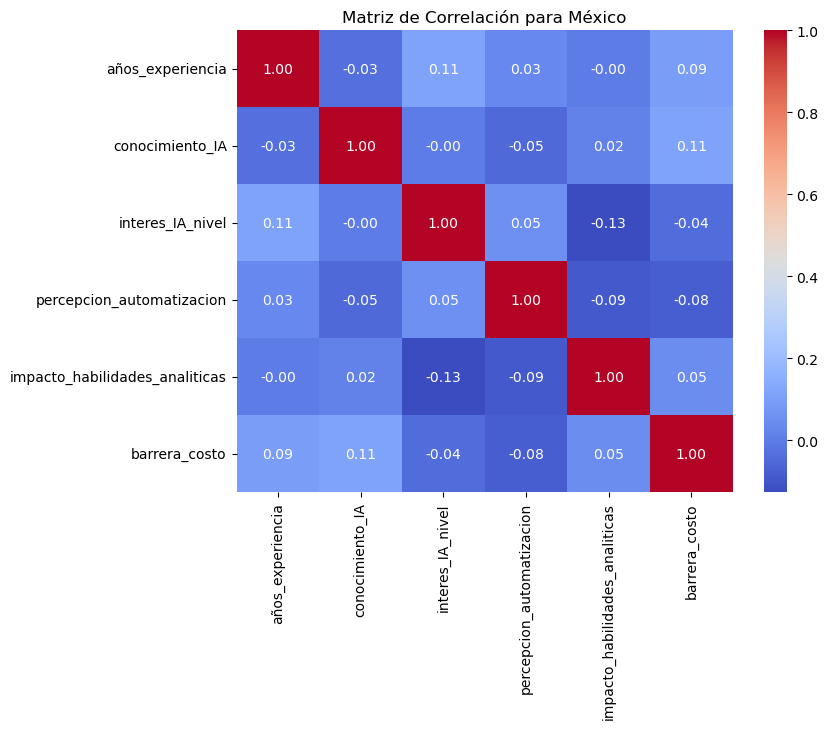


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


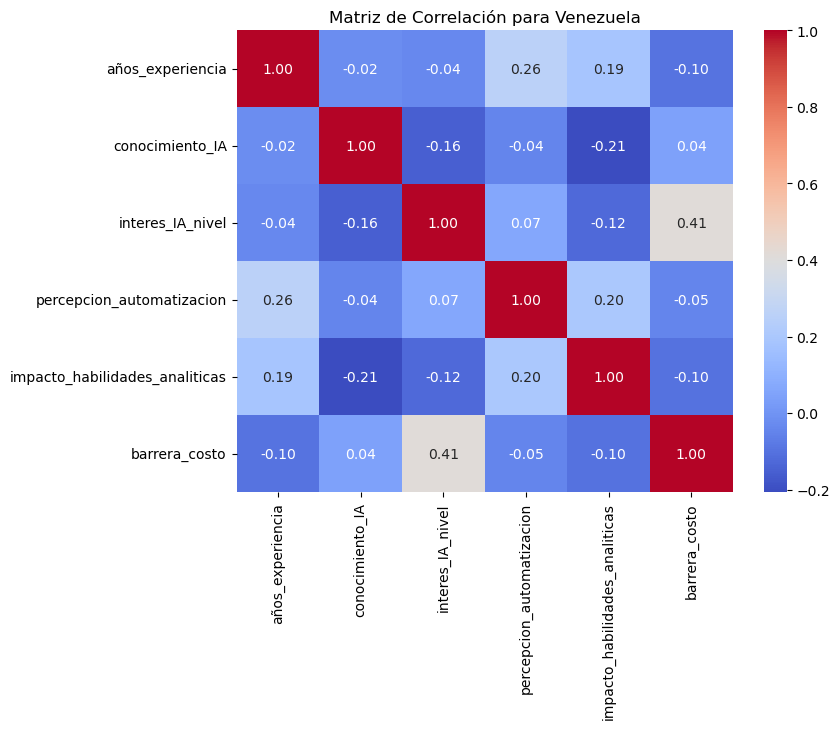


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


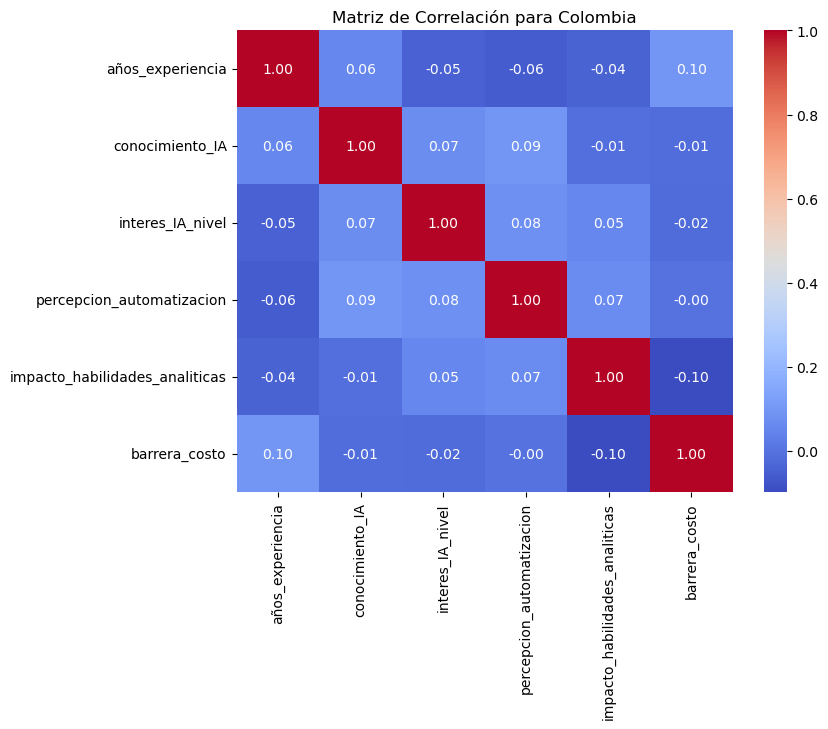



--- Comparaciones de Medias entre Grupos ---

[ANOVA] Comparando 'conocimiento_IA' por País:
  - p-valor = 0.9782
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'interes_IA_nivel' por País:
  - p-valor = 0.5041
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_automatizacion' por País:
  - p-valor = 0.9745
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_eficiencia' por País:
  - p-valor = 0.4846
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_riesgo_ciberseguridad' por País:
  - p-valor = 0.0634
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_habilidades_analiticas' por País:
  - p-valor = 0.9252
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_formacion_c

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Ampliación de las variables para la Matriz de Correlación
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = [
        'años_experiencia', 'conocimiento_IA', 'interes_IA_nivel',
        'percepcion_automatizacion', 'impacto_habilidades_analiticas', 'barrera_costo'
    ]
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Grupos (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Grupos ---")
# Ampliación de variables para ANOVA por país
variables_anova = [
    'conocimiento_IA', 'interes_IA_nivel',
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_riesgo_ciberseguridad',
    'impacto_habilidades_analiticas', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

# Ampliación de variables y grupos para T-tests
print("\n\n--- T-tests por País ---")
variables_ttest = [
    'conocimiento_IA', 'interes_IA_nivel', 'percepcion_automatizacion',
    'impacto_habilidades_analiticas', 'barrera_costo', 'barrera_resistencia_cambio'
]

# El bucle por país ahora contiene los T-tests
for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n======== {pais.upper()} ========")
    
    # Lista de pares de variables y grupos para comparar
    comparaciones = [
        ('genero', 'Masculino', 'Femenino'),
        ('uso_herramientas_IA_cat', 'Si', 'No'),
        ('tipo_organizacion', 'Empresa privada', 'Firma de contabilidad')
    ]

    for var in variables_ttest:
        for group_var, group1_val, group2_val in comparaciones:
            grupo1 = df_pais[df_pais[group_var] == group1_val][var]
            grupo2 = df_pais[df_pais[group_var] == group2_val][var]

            if len(grupo1) > 1 and len(grupo2) > 1:
                t_stat, p_value = ttest_ind(grupo1, grupo2, nan_policy='omit')
                print(f"  - T-test: '{var}' vs. '{group_var}' ({group1_val} vs {group2_val}) (p={p_value:.4f})")

                # Analizar y mostrar las medias solo si el resultado es significativo
                if p_value < 0.05:
                    media_grupo1 = grupo1.mean()
                    media_grupo2 = grupo2.mean()
                    print(f"    - Media de '{group1_val}': {media_grupo1:.2f}")
                    print(f"    - Media de '{group2_val}': {media_grupo2:.2f}")

                    if media_grupo1 > media_grupo2:
                        print(f"    - Conclusión: El grupo '{group1_val}' tiene un valor medio más alto.")
                    else:
                        print(f"    - Conclusión: El grupo '{group2_val}' tiene un valor medio más alto.")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables (Modelos más robustos)
# --------------------------
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define una lista base de predictores demográficos y profesionales
base_demograficos_profesionales = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# Define una lista de todas las variables de percepción, impacto y barreras
variables_percepcion_impacto_barrera = [
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_precisión',
    'percepcion_riesgo_ciberseguridad', 'percepcion_riesgo_sesgo', 'percepcion_reemplazo_rol',
    'percepcion_mejorar_asesoramiento', 'percepcion_inversion_necesaria', 'percepcion_facil_implementacion',
    'impacto_habilidades_analiticas', 'impacto_habilidades_sociales', 'impacto_cambio_funciones',
    'impacto_creacion_nuevos_roles', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'impacto_etica_profesional',
    'barrera_conocimiento_falta', 'barrera_costo', 'barrera_resistencia_cambio', 'barrera_regulacion'
]

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors: Conocimiento, Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_uso_ia = ['conocimiento_IA', 'interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA' ---")
# Predictors: Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_conocimiento = ['interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors: Conocimiento, Percepciones, Impactos, Barreras, Demográficos
predictors_interes = ['conocimiento_IA'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento de Respuestas Abiertas ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


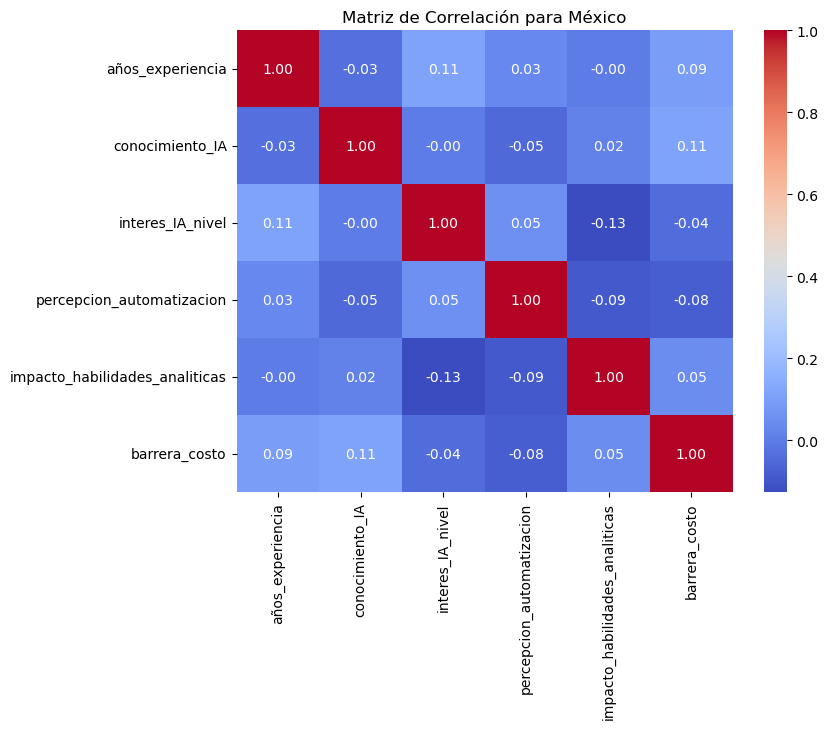


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


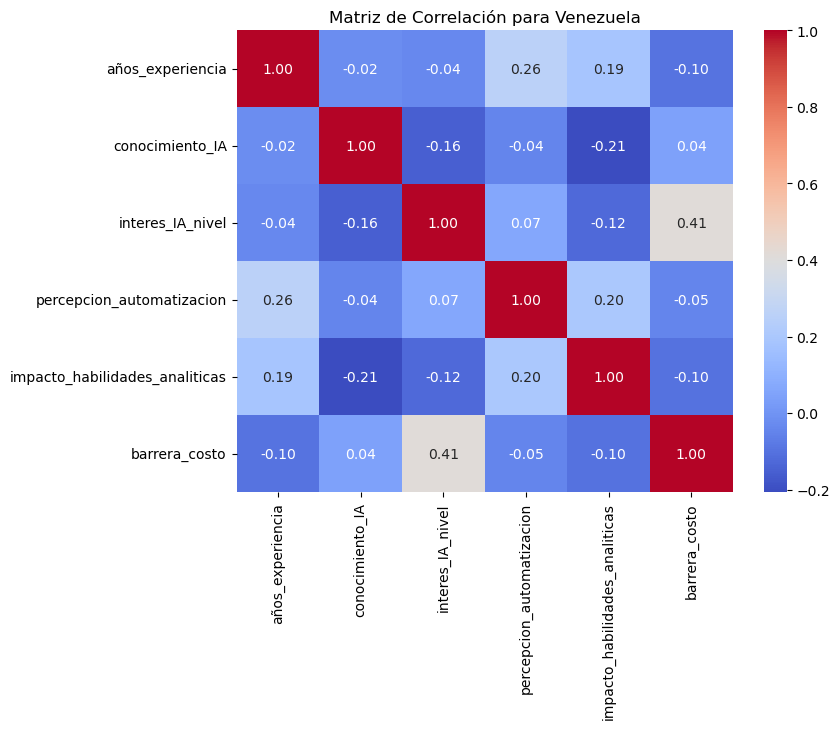


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


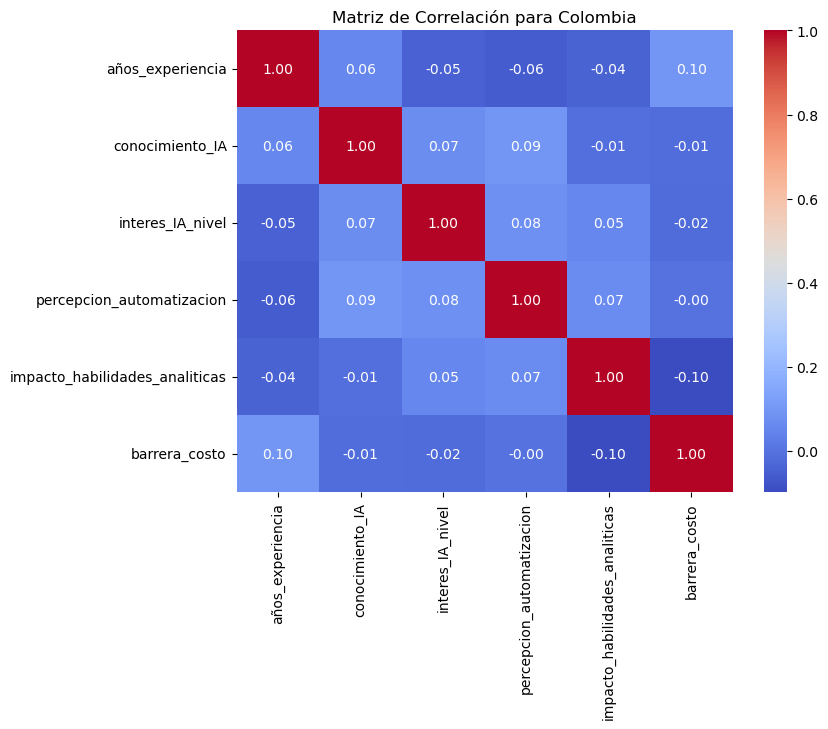



--- Comparaciones de Medias entre Grupos ---

[ANOVA] Comparando 'conocimiento_IA' por País:
  - p-valor = 0.9782
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'interes_IA_nivel' por País:
  - p-valor = 0.5041
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_automatizacion' por País:
  - p-valor = 0.9745
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_eficiencia' por País:
  - p-valor = 0.4846
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_riesgo_ciberseguridad' por País:
  - p-valor = 0.0634
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_habilidades_analiticas' por País:
  - p-valor = 0.9252
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_formacion_c

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Ampliación de las variables para la Matriz de Correlación
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = [
        'años_experiencia', 'conocimiento_IA', 'interes_IA_nivel',
        'percepcion_automatizacion', 'impacto_habilidades_analiticas', 'barrera_costo'
    ]
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Grupos (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Grupos ---")
# Ampliación de variables para ANOVA por país
variables_anova = [
    'conocimiento_IA', 'interes_IA_nivel',
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_riesgo_ciberseguridad',
    'impacto_habilidades_analiticas', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

# Ampliación de variables y grupos para T-tests
print("\n\n--- T-tests por País ---")
variables_ttest = [
    'conocimiento_IA', 'interes_IA_nivel', 'percepcion_automatizacion',
    'impacto_habilidades_analiticas', 'barrera_costo', 'barrera_resistencia_cambio'
]

# El bucle por país ahora contiene los T-tests
for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n======== {pais.upper()} ========")
    
    # Lista de pares de variables y grupos para comparar
    comparaciones = [
        ('genero', 'Masculino', 'Femenino'),
        ('uso_herramientas_IA_cat', 'Si', 'No'),
        ('tipo_organizacion', 'Empresa privada', 'Firma de contabilidad')
    ]

    for var in variables_ttest:
        for group_var, group1_val, group2_val in comparaciones:
            grupo1 = df_pais[df_pais[group_var] == group1_val][var]
            grupo2 = df_pais[df_pais[group_var] == group2_val][var]

            if len(grupo1) > 1 and len(grupo2) > 1:
                t_stat, p_value = ttest_ind(grupo1, grupo2, nan_policy='omit')
                print(f"  - T-test: '{var}' vs. '{group_var}' ({group1_val} vs {group2_val}) (p={p_value:.4f})")

                # Analizar y mostrar las medias solo si el resultado es significativo
                if p_value < 0.05:
                    media_grupo1 = grupo1.mean()
                    media_grupo2 = grupo2.mean()
                    print(f"    - Media de '{group1_val}': {media_grupo1:.2f}")
                    print(f"    - Media de '{group2_val}': {media_grupo2:.2f}")

                    if media_grupo1 > media_grupo2:
                        print(f"    - Conclusión: El grupo '{group1_val}' tiene un valor medio más alto.")
                    else:
                        print(f"    - Conclusión: El grupo '{group2_val}' tiene un valor medio más alto.")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables (Modelos más robustos)
# --------------------------
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define una lista base de predictores demográficos y profesionales
base_demograficos_profesionales = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# Define una lista de todas las variables de percepción, impacto y barreras
variables_percepcion_impacto_barrera = [
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_precisión',
    'percepcion_riesgo_ciberseguridad', 'percepcion_riesgo_sesgo', 'percepcion_reemplazo_rol',
    'percepcion_mejorar_asesoramiento', 'percepcion_inversion_necesaria', 'percepcion_facil_implementacion',
    'impacto_habilidades_analiticas', 'impacto_habilidades_sociales', 'impacto_cambio_funciones',
    'impacto_creacion_nuevos_roles', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'impacto_etica_profesional',
    'barrera_conocimiento_falta', 'barrera_costo', 'barrera_resistencia_cambio', 'barrera_regulacion'
]

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors: Conocimiento, Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_uso_ia = ['conocimiento_IA', 'interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA' ---")
# Predictors: Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_conocimiento = ['interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors: Conocimiento, Percepciones, Impactos, Barreras, Demográficos
predictors_interes = ['conocimiento_IA'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento de Respuestas Abiertas ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


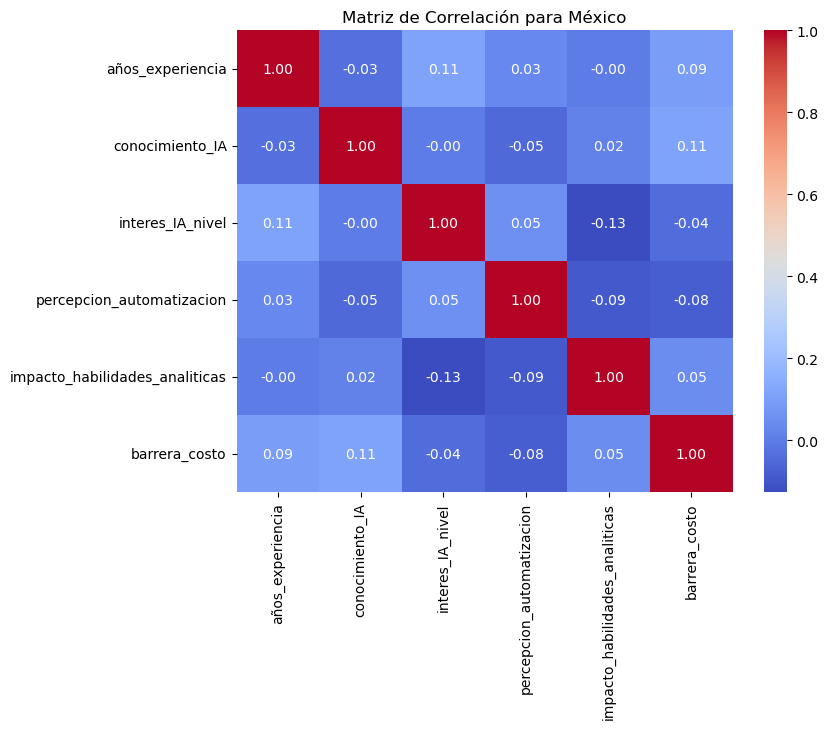


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


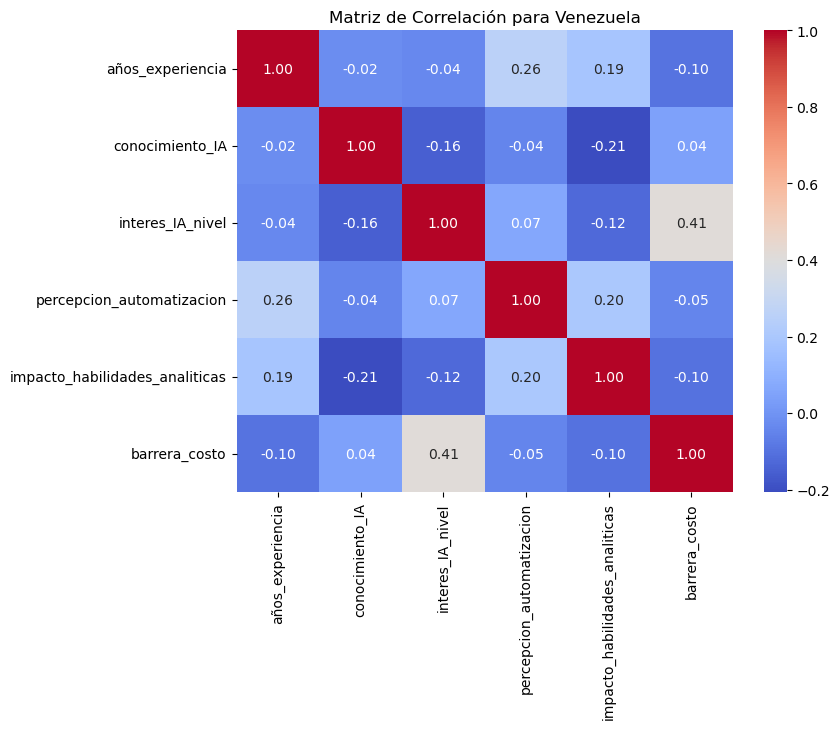


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


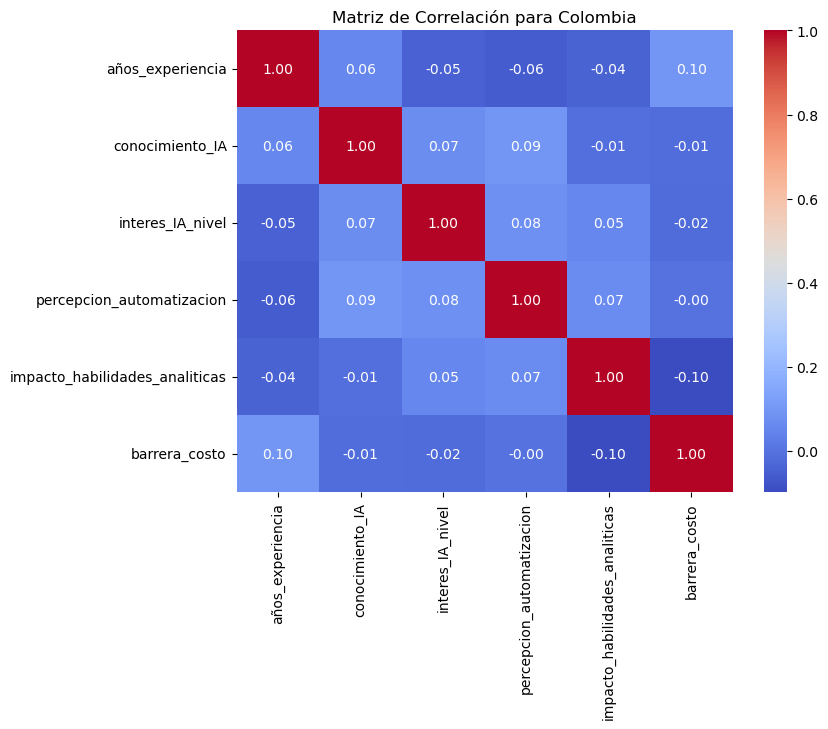



--- Comparaciones de Medias entre Grupos ---

[ANOVA] Comparando 'conocimiento_IA' por País:
  - p-valor = 0.9782
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'interes_IA_nivel' por País:
  - p-valor = 0.5041
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_automatizacion' por País:
  - p-valor = 0.9745
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_eficiencia' por País:
  - p-valor = 0.4846
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_riesgo_ciberseguridad' por País:
  - p-valor = 0.0634
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_habilidades_analiticas' por País:
  - p-valor = 0.9252
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_formacion_c

In [20]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Ampliación de las variables para la Matriz de Correlación
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = [
        'años_experiencia', 'conocimiento_IA', 'interes_IA_nivel',
        'percepcion_automatizacion', 'impacto_habilidades_analiticas', 'barrera_costo'
    ]
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Grupos (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Grupos ---")
# Ampliación de variables para ANOVA por país
variables_anova = [
    'conocimiento_IA', 'interes_IA_nivel',
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_riesgo_ciberseguridad',
    'impacto_habilidades_analiticas', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
        # Realizar prueba post-hoc de Tukey si el resultado es significativo
        tukey_result = pairwise_tukeyhsd(df[var], df['pais'], alpha=0.05)
        print("\n  [Prueba Post-Hoc (Tukey HSD)]")
        print(tukey_result)
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

# Ampliación de variables y grupos para T-tests
print("\n\n--- T-tests por País ---")
variables_ttest = [
    'conocimiento_IA', 'interes_IA_nivel', 'percepcion_automatizacion',
    'impacto_habilidades_analiticas', 'barrera_costo', 'barrera_resistencia_cambio'
]

# El bucle por país ahora contiene los T-tests
for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n======== {pais.upper()} ========")
    
    # Lista de pares de variables y grupos para comparar
    comparaciones = [
        ('genero', 'Masculino', 'Femenino'),
        ('uso_herramientas_IA_cat', 'Si', 'No'),
        ('tipo_organizacion', 'Empresa privada', 'Firma de contabilidad')
    ]

    for var in variables_ttest:
        for group_var, group1_val, group2_val in comparaciones:
            grupo1 = df_pais[df_pais[group_var] == group1_val][var]
            grupo2 = df_pais[df_pais[group_var] == group2_val][var]

            if len(grupo1) > 1 and len(grupo2) > 1:
                t_stat, p_value = ttest_ind(grupo1, grupo2, nan_policy='omit')
                print(f"  - T-test: '{var}' vs. '{group_var}' ({group1_val} vs {group2_val}) (p={p_value:.4f})")

                # Analizar y mostrar las medias solo si el resultado es significativo
                if p_value < 0.05:
                    media_grupo1 = grupo1.mean()
                    media_grupo2 = grupo2.mean()
                    print(f"    - Media de '{group1_val}': {media_grupo1:.2f}")
                    print(f"    - Media de '{group2_val}': {media_grupo2:.2f}")

                    if media_grupo1 > media_grupo2:
                        print(f"    - Conclusión: El grupo '{group1_val}' tiene un valor medio más alto.")
                    else:
                        print(f"    - Conclusión: El grupo '{group2_val}' tiene un valor medio más alto.")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables (Modelos más robustos)
# --------------------------
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define una lista base de predictores demográficos y profesionales
base_demograficos_profesionales = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# Define una lista de todas las variables de percepción, impacto y barreras
variables_percepcion_impacto_barrera = [
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_precisión',
    'percepcion_riesgo_ciberseguridad', 'percepcion_riesgo_sesgo', 'percepcion_reemplazo_rol',
    'percepcion_mejorar_asesoramiento', 'percepcion_inversion_necesaria', 'percepcion_facil_implementacion',
    'impacto_habilidades_analiticas', 'impacto_habilidades_sociales', 'impacto_cambio_funciones',
    'impacto_creacion_nuevos_roles', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'impacto_etica_profesional',
    'barrera_conocimiento_falta', 'barrera_costo', 'barrera_resistencia_cambio', 'barrera_regulacion'
]

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors: Conocimiento, Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_uso_ia = ['conocimiento_IA', 'interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA' ---")
# Predictors: Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_conocimiento = ['interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors: Conocimiento, Percepciones, Impactos, Barreras, Demográficos
predictors_interes = ['conocimiento_IA'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento de Respuestas Abiertas ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")



--- Análisis de Relaciones por País ---

======== MÉXICO ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


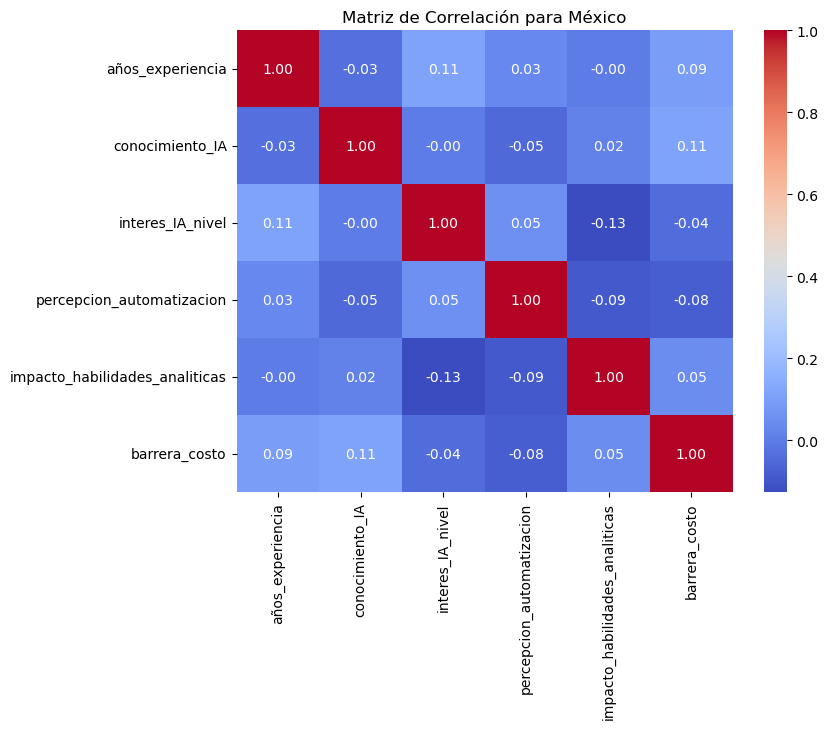


======== VENEZUELA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


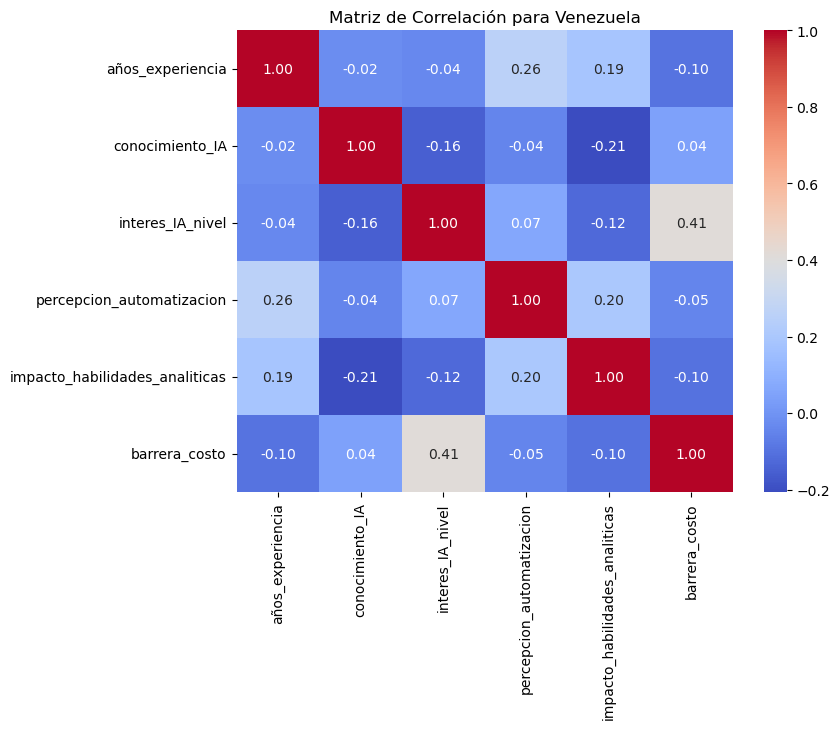


======== COLOMBIA ========

[Relaciones Categóricas (Chi-Cuadrado)]

[Relaciones Numéricas (Correlación de Pearson)]


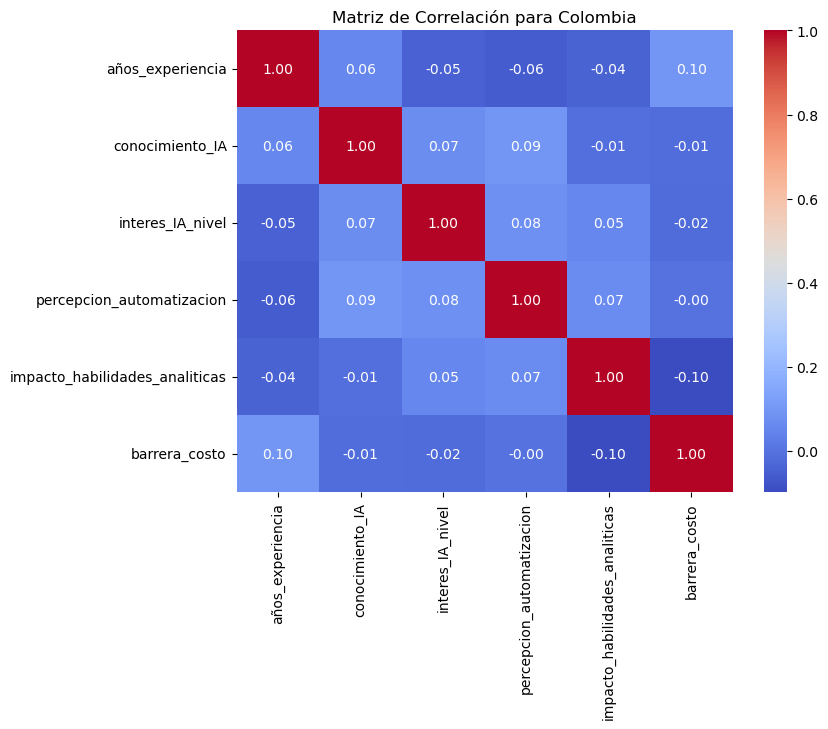



--- Comparaciones de Medias entre Grupos ---

[ANOVA] Comparando 'conocimiento_IA' por País:
  - p-valor = 0.9782
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'interes_IA_nivel' por País:
  - p-valor = 0.5041
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_automatizacion' por País:
  - p-valor = 0.9745
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_eficiencia' por País:
  - p-valor = 0.4846
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'percepcion_riesgo_ciberseguridad' por País:
  - p-valor = 0.0634
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_habilidades_analiticas' por País:
  - p-valor = 0.9252
  - No hay una diferencia significativa entre los países en esta variable.

[ANOVA] Comparando 'impacto_formacion_c

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Semilla para reproducibilidad
np.random.seed(42)
n_samples = 500

# --------------------------
# 1. Generación de Datos para las 38 Preguntas de la Encuesta
# --------------------------
data = {
    # Sección I: Información Demográfica y Profesional
    'pais': np.random.choice(['México', 'Colombia', 'Venezuela'], size=n_samples, p=[0.45, 0.45, 0.1]), # P1
    'genero': np.random.choice(['Masculino', 'Femenino', 'Prefiero no decirlo'], size=n_samples, p=[0.5, 0.45, 0.05]), # P2
    'rango_edad': np.random.choice(['<25', '25-34', '35-44', '45-54', '55+'], size=n_samples, p=[0.1, 0.3, 0.25, 0.2, 0.15]), # P3
    'rol_profesional': np.random.choice(['Asistente', 'Analista', 'Contador', 'Gerente', 'Socio/Director'], size=n_samples, p=[0.2, 0.2, 0.3, 0.2, 0.1]), # P4
    'años_experiencia': np.random.randint(1, 40, size=n_samples), # P5
    'tipo_organizacion': np.random.choice(['Empresa privada', 'Sector público', 'Firma de contabilidad', 'Independiente'], size=n_samples, p=[0.4, 0.1, 0.35, 0.15]), # P6
    'tamaño_empresa': np.random.choice(['1-10', '11-50', '51-200', '201-500', '501+'], size=n_samples, p=[0.2, 0.3, 0.2, 0.15, 0.15]), # P7
    
    # Sección II: Adopción y Uso de IA
    'conocimiento_IA': np.random.randint(1, 6, size=n_samples), # P8
    'uso_herramientas_IA': np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4]), # P9
    'frecuencia_uso_IA': np.random.choice(['Nunca', 'Mensual', 'Semanal', 'Diario'], size=n_samples, p=[0.6, 0.2, 0.1, 0.1]), # P10
    'herramientas_uso': [np.random.choice(['Excel', 'QuickBooks', 'Xero', 'Chatbots', 'Software AI'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P11

    # Sección III: Percepción de la IA (P12-P20)
    'percepcion_automatizacion': np.random.randint(1, 6, size=n_samples), # P12
    'percepcion_eficiencia': np.random.randint(1, 6, size=n_samples), # P13
    'percepcion_precisión': np.random.randint(1, 6, size=n_samples), # P14
    'percepcion_riesgo_ciberseguridad': np.random.randint(1, 6, size=n_samples), # P15
    'percepcion_riesgo_sesgo': np.random.randint(1, 6, size=n_samples), # P16
    'percepcion_reemplazo_rol': np.random.randint(1, 6, size=n_samples), # P17
    'percepcion_mejorar_asesoramiento': np.random.randint(1, 6, size=n_samples), # P18
    'percepcion_inversion_necesaria': np.random.randint(1, 6, size=n_samples), # P19
    'percepcion_facil_implementacion': np.random.randint(1, 6, size=n_samples), # P20

    # Sección IV: Impacto en la Profesión (P21-P27)
    'impacto_habilidades_analiticas': np.random.randint(1, 6, size=n_samples), # P21
    'impacto_habilidades_sociales': np.random.randint(1, 6, size=n_samples), # P22
    'impacto_cambio_funciones': np.random.randint(1, 6, size=n_samples), # P23
    'impacto_creacion_nuevos_roles': np.random.randint(1, 6, size=n_samples), # P24
    'impacto_formacion_continua': np.random.randint(1, 6, size=n_samples), # P25
    'impacto_reduccion_costos': np.random.randint(1, 6, size=n_samples), # P26
    'impacto_etica_profesional': np.random.randint(1, 6, size=n_samples), # P27

    # Sección V: Barreras y Facilitadores (P28-P31)
    'barrera_conocimiento_falta': np.random.randint(1, 6, size=n_samples), # P28
    'barrera_costo': np.random.randint(1, 6, size=n_samples), # P29
    'barrera_resistencia_cambio': np.random.randint(1, 6, size=n_samples), # P30
    'barrera_regulacion': np.random.randint(1, 6, size=n_samples), # P31

    # Sección VI: Preparación para el Futuro
    'interes_IA_nivel': np.random.randint(1, 6, size=n_samples), # P32
    'habilidades_futuro': [np.random.choice(['Análisis de datos', 'Pensamiento crítico', 'Asesoramiento estratégico', 'Conocimiento TI', 'Habilidades comunicación', 'Ética'], size=np.random.randint(1, 4), replace=False) for _ in range(n_samples)], # P33

    # Sección VII: Preguntas Abiertas
    'oportunidad_abierta': np.random.choice(["La automatización es clave.", "Mayor eficiencia.", "Mejora en el análisis de datos."], size=n_samples), # P34
    'riesgo_abierta': np.random.choice(["Pérdida de empleos.", "Ciberseguridad.", "Falta de regulación."], size=n_samples), # P35
    'condiciones_abierta': np.random.choice(["Falta de políticas públicas.", "La economía es inestable.", "Falta de inversión en tecnología."], size=n_samples), # P36
    'consejo_abierta': np.random.choice(["Enfócate en habilidades blandas.", "Aprende de datos.", "No le temas a la tecnología."], size=n_samples), # P37
}

df = pd.DataFrame(data)

# Mapeo de edad y creación de variables categóricas
rango_edad_map = {'<25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55+': 60}
df['edad_numerica'] = df['rango_edad'].map(rango_edad_map)
df['uso_herramientas_IA_cat'] = df['uso_herramientas_IA'].apply(lambda x: 'Si' if x == 1 else 'No')

# --------------------------
# 2. Análisis de Relación: Variables Numéricas y Categóricas
# --------------------------

print("\n\n--- Análisis de Relaciones por País ---")
paises = df['pais'].unique()
for pais in paises:
    df_pais = df[df['pais'] == pais]
    print(f"\n======== {pais.upper()} ========")

    # Relaciones entre variables categóricas (Chi-Cuadrado)
    print("\n[Relaciones Categóricas (Chi-Cuadrado)]")
    categoricas = ['genero', 'tipo_organizacion', 'uso_herramientas_IA_cat']
    for i in range(len(categoricas)):
        for j in range(i + 1, len(categoricas)):
            var1, var2 = categoricas[i], categoricas[j]
            crosstab = pd.crosstab(df_pais[var1], df_pais[var2])
            if crosstab.min().min() > 0:
                chi2, p, _, _ = chi2_contingency(crosstab)
                if p < 0.05:
                    print(f"  - Relación entre {var1} y {var2} (p={p:.4f})")

    # Ampliación de las variables para la Matriz de Correlación
    print("\n[Relaciones Numéricas (Correlación de Pearson)]")
    numericas = [
        'años_experiencia', 'conocimiento_IA', 'interes_IA_nivel',
        'percepcion_automatizacion', 'impacto_habilidades_analiticas', 'barrera_costo'
    ]
    corr_matrix = df_pais[numericas].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriz de Correlación para {pais}')
    plt.show()

# --------------------------
# 3. Comparaciones entre Grupos (ANOVA & T-tests)
# --------------------------

print("\n\n--- Comparaciones de Medias entre Grupos ---")
# Ampliación de variables para ANOVA por país
variables_anova = [
    'conocimiento_IA', 'interes_IA_nivel',
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_riesgo_ciberseguridad',
    'impacto_habilidades_analiticas', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'barrera_costo', 'barrera_resistencia_cambio'
]
for var in variables_anova:
    grupos = [df[df['pais'] == p][var] for p in paises]
    f_stat, p_value = f_oneway(*grupos, nan_policy='omit')
    print(f"\n[ANOVA] Comparando '{var}' por País:")
    print(f"  - p-valor = {p_value:.4f}")
    if p_value < 0.05:
        print("  - ¡Hay una diferencia significativa entre los países en esta variable!")
        # Realizar prueba post-hoc de Tukey si el resultado es significativo
        tukey_result = pairwise_tukeyhsd(df[var], df['pais'], alpha=0.05)
        print("\n  [Prueba Post-Hoc (Tukey HSD)]")
        print(tukey_result)
    else:
        print("  - No hay una diferencia significativa entre los países en esta variable.")

# Ampliación de variables y grupos para T-tests
print("\n\n--- T-tests por País ---")
variables_ttest = [
    'conocimiento_IA', 'interes_IA_nivel', 'percepcion_automatizacion',
    'impacto_habilidades_analiticas', 'barrera_costo', 'barrera_resistencia_cambio'
]

# El bucle por país ahora contiene los T-tests
for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n======== {pais.upper()} ========")
    
    # Lista de pares de variables y grupos para comparar
    comparaciones = [
        ('genero', 'Masculino', 'Femenino'),
        ('uso_herramientas_IA_cat', 'Si', 'No'),
        ('tipo_organizacion', 'Empresa privada', 'Firma de contabilidad')
    ]

    for var in variables_ttest:
        for group_var, group1_val, group2_val in comparaciones:
            grupo1 = df_pais[df_pais[group_var] == group1_val][var]
            grupo2 = df_pais[df_pais[group_var] == group2_val][var]

            if len(grupo1) > 1 and len(grupo2) > 1:
                t_stat, p_value = ttest_ind(grupo1, grupo2, nan_policy='omit')
                print(f"  - T-test: '{var}' vs. '{group_var}' ({group1_val} vs {group2_val}) (p={p_value:.4f})")

                # Analizar y mostrar las medias solo si el resultado es significativo
                if p_value < 0.05:
                    media_grupo1 = grupo1.mean()
                    media_grupo2 = grupo2.mean()
                    print(f"    - Media de '{group1_val}': {media_grupo1:.2f}")
                    print(f"    - Media de '{group2_val}': {media_grupo2:.2f}")

                    if media_grupo1 > media_grupo2:
                        print(f"    - Conclusión: El grupo '{group1_val}' tiene un valor medio más alto.")
                    else:
                        print(f"    - Conclusión: El grupo '{group2_val}' tiene un valor medio más alto.")

# --------------------------
# 4. Análisis de Regresión para Múltiples Variables (Modelos más robustos)
# --------------------------
df_reg = df.copy()
df_reg = pd.get_dummies(df_reg, columns=['pais', 'genero', 'rango_edad', 'tipo_organizacion', 'tamaño_empresa', 'rol_profesional'], drop_first=True)

# Define una lista base de predictores demográficos y profesionales
base_demograficos_profesionales = ['años_experiencia'] + list(df_reg.filter(regex='(pais|genero|rango|tipo|tamaño|rol)_').columns)

# Define una lista de todas las variables de percepción, impacto y barreras
variables_percepcion_impacto_barrera = [
    'percepcion_automatizacion', 'percepcion_eficiencia', 'percepcion_precisión',
    'percepcion_riesgo_ciberseguridad', 'percepcion_riesgo_sesgo', 'percepcion_reemplazo_rol',
    'percepcion_mejorar_asesoramiento', 'percepcion_inversion_necesaria', 'percepcion_facil_implementacion',
    'impacto_habilidades_analiticas', 'impacto_habilidades_sociales', 'impacto_cambio_funciones',
    'impacto_creacion_nuevos_roles', 'impacto_formacion_continua', 'impacto_reduccion_costos',
    'impacto_etica_profesional',
    'barrera_conocimiento_falta', 'barrera_costo', 'barrera_resistencia_cambio', 'barrera_regulacion'
]

# --- Modelo 1: Prediciendo el USO de la IA (Regresión Logística) ---
print("\n\n--- Regresión Logística: Prediciendo 'uso_herramientas_IA' ---")
# Predictors: Conocimiento, Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_uso_ia = ['conocimiento_IA', 'interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_uso_ia = df_reg[predictors_uso_ia].astype(float)
y_uso_ia = df_reg['uso_herramientas_IA']
X_uso_ia = sm.add_constant(X_uso_ia)
modelo_logistico = sm.Logit(y_uso_ia, X_uso_ia).fit()
print(modelo_logistico.summary())

# --- Modelo 2: Prediciendo el NIVEL DE CONOCIMIENTO de la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'conocimiento_IA' ---")
# Predictors: Interes, Percepciones, Impactos, Barreras, Demográficos
predictors_conocimiento = ['interes_IA_nivel'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_conocimiento = df_reg[predictors_conocimiento].astype(float)
y_conocimiento = df_reg['conocimiento_IA']
X_conocimiento = sm.add_constant(X_conocimiento)
modelo_lineal_conocimiento = sm.OLS(y_conocimiento, X_conocimiento).fit()
print(modelo_lineal_conocimiento.summary())

# --- Modelo 3: Prediciendo el INTERÉS en la IA (Regresión Lineal) ---
print("\n\n--- Regresión Lineal: Prediciendo 'interes_IA_nivel' ---")
# Predictors: Conocimiento, Percepciones, Impactos, Barreras, Demográficos
predictors_interes = ['conocimiento_IA'] + variables_percepcion_impacto_barrera + base_demograficos_profesionales
X_interes = df_reg[predictors_interes].astype(float)
y_interes = df_reg['interes_IA_nivel']
X_interes = sm.add_constant(X_interes)
modelo_lineal_interes = sm.OLS(y_interes, X_interes).fit()
print(modelo_lineal_interes.summary())

# --------------------------
# 5. Análisis de Sentimiento de Respuestas Abiertas
# --------------------------
def analizar_sentimiento(df_to_analyze, column_name):
    df_with_sentiment = df_to_analyze.copy()
    df_with_sentiment.loc[:, f'sentimiento_{column_name}'] = df_with_sentiment[column_name].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df_with_sentiment

print("\n\n--- Análisis de Sentimiento de Respuestas Abiertas ---")
preguntas_abiertas = ['oportunidad_abierta', 'riesgo_abierta', 'condiciones_abierta', 'consejo_abierta']

for pais in paises:
    df_pais = df[df['pais'] == pais].copy()
    print(f"\n[Resultados de Sentimiento para {pais}]")
    for q_abierta in preguntas_abiertas:
        df_pais = analizar_sentimiento(df_pais, q_abierta)
        promedio = df_pais[f'sentimiento_{q_abierta}'].mean()
        
        sentimiento_etiqueta = "Neutral"
        if promedio > 0.1:
            sentimiento_etiqueta = "Positivo"
        elif promedio < -0.1:
            sentimiento_etiqueta = "Negativo"
            
        print(f"  - Sentimiento de '{q_abierta}': Polaridad promedio = {promedio:.2f} ({sentimiento_etiqueta})")